# ML Project by Aun Muhammad Ashraf and Anas Semsayan (15-288)

## D2 Submission : Data Ingestion & Processing Pipeline - Data Acquisition, Analysis, Wrangling, Feature Engineering

# Table of Contents

- [D2.1 Simulating a Synthetic Dataset](#d21-simulating-a-synthetic-dataset)  
  - [Why simulate data?](#why-simulate-data)  
  - [What we simulate](#what-we-simulate)  
  - [Injecting realism](#injecting-realism)  
- [Corrupting of Data](#corrupting-of-data)  
- [D2.2 Exploratory Data Analysis](#d22-exploratory-data-analysis)  
- [D2.3 Data Wrangling](#d23-data-wrangling)  
- [D2.4 Feature Engineering](#d24-feature-engineering)  
  - [1. Feature Importance: Correlation with Target](#1-feature-importance-correlation-with-target)  
  - [2. Prune Redundant Features](#2-prune-redundant-features)  
  - [3. Feature Creation](#3-feature-creation)  
  - [4. Feature Scaling](#4-feature-scaling)  
- [Targeted Final Exploratory DATA ANALYSIS](#targeted-final-exploratory-data-analysis)
- [Final Summary](#targeted-final-exploratory-data-analysis)


# D2.1 Simulating a Synthetic Dataset

### Why simulate data?
Since we don’t have access to a real dataset, we simulate one that mimics the structure of university course difficulty evaluations. This allows us to control and inject patterns that mirror real-world behaviors.

 ### What we simulate
Course structure: assignments_per_week, hours_per_week, units, projects

Instructor and course quality: professor_rating, course_rating, sentiment_score, grading_strictness

Student performance proxies: student_percentage_estimate, drop_rate, failure_rate

Target: difficulty_level (Easy, Medium, Hard) is derived from a weighted scoring system

### Injecting realism
We:

Introduce missing values

Add outliers (e.g., 45 hours/week)

--------------------------------------

In this piece of code we are simulating a synthetic dataset of 50,000 university courses by generating realistic academic features such as professor rating, grading strictness, student performance, and engagement metrics using probabilistic sampling and rule-based calculations.

In [156]:
import pandas as pd
import numpy as np
import random

# Set seed for reproducibility
np.random.seed(42)
random.seed(42)

# Number of data points
num_samples = 50000

# Generate independent features first
prof_rating_choices = [1.0, 2.0, 3.0, 4.0, 5.0]
prof_rating_probs = [0.15, 0.20, 0.35, 0.25, 0.05]  #
# Random choice (weighted)
professor_rating = np.random.choice(prof_rating_choices, size=num_samples, p=prof_rating_probs)

grading_strictness = np.round(np.random.uniform(1.0, 5.0, num_samples), 1)
assignments_per_week = np.random.randint(0, 6, num_samples)
attendance_required = np.random.choice([0, 1], num_samples)
# course_level = np.random.choice(['Undergrad', 'Grad', 'Elective', 'Core'], num_samples)
projects = np.random.choice([0, 1], num_samples)
midterms_count = np.random.randint(0, 3, num_samples)
final_exam = np.random.choice([0, 1], num_samples)
subject_area = np.random.choice(['STEM', 'Humanities', 'Social Science'], num_samples)

# New features
unit_choices = [3, 3, 3, 6, 9, 9, 9, 9, 9, 12, 12]
units = np.random.choice(unit_choices, num_samples)

# Stronger link between units and hours (with variation to simulate 'easy' courses)

subject_penalty = [5 if s == 'STEM' else -3 if s == 'Humanities' else 0 for s in subject_area]
student_percentage_estimate = (
    90 - 5 * grading_strictness - np.array(subject_penalty) + np.random.normal(0, 5, num_samples)
)

student_percentage_estimate = np.clip(student_percentage_estimate, 50, 100)
student_percentage_estimate = np.round(student_percentage_estimate, 1)

# Failure rate derived from inverse of student performance with noise
failure_rate = np.clip((100 - student_percentage_estimate) / 100 + np.random.normal(0, 0.05, num_samples), 0, 0.4)
failure_rate = np.round(failure_rate, 2)

# Drop rate now related to failure rate with some noise
drop_rate = np.clip(failure_rate * 0.7 + np.random.normal(0, 0.03, num_samples), 0, 0.3)
drop_rate = np.round(drop_rate, 2)

hours_per_week = (
    0.5 * assignments_per_week * np.random.uniform(2.0, 3.0, num_samples) +
    0.7 * units +
    0.2 * (100 - student_percentage_estimate) * 0.1 +
    np.random.normal(0, 1.0, num_samples)
)
hours_per_week = np.clip(hours_per_week, 1, 20).astype(int)

# Course rating influenced by prof rating & grading strictness
course_rating = 1 * professor_rating - 0.2 * grading_strictness + np.random.normal(0, 0.5, num_samples)
course_rating = np.clip(course_rating, 1.0, 5.0)
course_rating = np.round(course_rating, 1)

# Sentiment score depends on course rating, prof rating, and drop rate
sentiment_score = (
    0.25 * (course_rating - 3) +
    0.25 * (professor_rating - 3) -
    0.5 * drop_rate +
    np.random.normal(0, 0.5, num_samples)
)
sentiment_score = np.clip(sentiment_score, -1.0, 1.0)
sentiment_score = np.round(sentiment_score, 2)


---------------------

In this section, we combine all the generated features into a single DataFrame and fill any missing values for professor_rating and sentiment_score. We then define a custom assign_difficulty function that calculates a raw difficulty score for each course based on various factors such as workload, grading strictness, student feedback, and subject area, with additional weight given to STEM courses. Using these scores, we label each course as "Easy", "Medium", or "Hard" to create a 30-50-20 difficulty distribution across the dataset. Finally, we shuffle the dataset to randomize the row order for fairness and realism.

In [160]:
# Combine into DataFrame
df = pd.DataFrame({
    'course_rating': course_rating,
    'assignments_per_week': assignments_per_week,
    'attendance_required': attendance_required,
    'professor_rating': np.round(professor_rating, 1),
    'sentiment_score': sentiment_score,
    # 'course_level': course_level,
    'subject_area': subject_area,
    'units': units,
    'hours_per_week': hours_per_week,
    'projects': projects,
    'midterms_count': midterms_count,
    'final_exam': final_exam,
    'grading_strictness': grading_strictness,
    'student_percentage_estimate': student_percentage_estimate,
    'drop_rate': drop_rate,
    'failure_rate': failure_rate
})

# Fill missing values for rating/sentiment simulation (temporarily)
df['professor_rating'].fillna(df['professor_rating'].mean(), inplace=True)
df['sentiment_score'].fillna(df['sentiment_score'].mean(), inplace=True)

# Difficulty scoring function with subject/failure/drop rate influence
def assign_difficulty(row):
    score = 0
    feedback_weight = (row['student_percentage_estimate'] - 50) / 50  # 0 to 1
    feedback_weight = np.clip(feedback_weight, 0, 1)

    # Apply subject-based weight multiplier (more weight in STEM)
    weight_multiplier = 1.3 if row['subject_area'] == 'STEM' else 1.0

    score += weight_multiplier * (row['assignments_per_week'] * 1.5)
    score += weight_multiplier * (row['attendance_required'] * 1.0)
    score -= weight_multiplier * (row['course_rating'] * 2 * feedback_weight)
    score -= weight_multiplier * (row['professor_rating'] * 1.2 * feedback_weight)
    score -= weight_multiplier * (row['sentiment_score'] * 5 * feedback_weight)
    score += weight_multiplier * (row['grading_strictness'] * 1.0)
    score += weight_multiplier * (row['hours_per_week'] * 0.3)
    score += weight_multiplier * (row['midterms_count'] * 1.2)
    score += weight_multiplier * (row['final_exam'] * 1.0)
    score += weight_multiplier * (row['projects'] * 0.8)
    score += weight_multiplier * ((100 - row['student_percentage_estimate']) * 0.05)
    score += weight_multiplier * ((row['units'] - row['hours_per_week']) * -0.3) #difference between units and hours per week
    score += weight_multiplier * (row['units'] * 0.3)
    score += weight_multiplier * (row['drop_rate'] * 10)
    score += weight_multiplier * (row['failure_rate'] * 8)
    score += np.random.normal(0, 1)

    return score

# Assign raw difficulty score for balancing
df['difficulty_score'] = df.apply(assign_difficulty, axis=1)

# Sort by score and assign labels to balance distribution (approx. 30-50-20)
df = df.sort_values(by='difficulty_score').reset_index(drop=True)
df.loc[:num_samples*0.3, 'difficulty_level'] = 'Easy'
df.loc[num_samples*0.3:num_samples*0.8, 'difficulty_level'] = 'Medium'
df.loc[num_samples*0.80:, 'difficulty_level'] = 'Hard'

# Final shuffle
df = df.sample(frac=1).reset_index(drop=True)

C:\Users\Aun Ashraf\AppData\Local\Temp\ipykernel_17320\288129989.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['professor_rating'].fillna(df['professor_rating'].mean(), inplace=True)
C:\Users\Aun Ashraf\AppData\Local\Temp\ipykernel_17320\288129989.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting value

This section defines 10 manually crafted anomaly cases with unusual feature combinations. Each is scored for difficulty, labeled as Easy, Medium, or Hard, and then added to the main dataset to enhance diversity and realism.

In [162]:
# Define 10 diverse anomaly rows
anomalies = pd.DataFrame([
    # 1. Zero assignments, high hours
    {'course_rating': 3.0, 'assignments_per_week': 0, 'attendance_required': 1,
     'professor_rating': 4.0, 'sentiment_score': 0.2, 'subject_area': 'STEM',
     'units': 6, 'hours_per_week': 20, 'projects': 1, 'midterms_count': 1, 'final_exam': 1,
     'grading_strictness': 3.0, 'student_percentage_estimate': 80, 'drop_rate': 0.05, 'failure_rate': 0.1},

    # 2. High GPA, high failure
    {'course_rating': 4.5, 'assignments_per_week': 3, 'attendance_required': 1,
     'professor_rating': 4.5, 'sentiment_score': 0.8, 'subject_area': 'STEM',
     'units': 9, 'hours_per_week': 12, 'projects': 1, 'midterms_count': 2, 'final_exam': 1,
     'grading_strictness': 4.0, 'student_percentage_estimate': 95, 'drop_rate': 0.05, 'failure_rate': 0.4},

    # 3. Humanities with extreme grading
    {'course_rating': 2.0, 'assignments_per_week': 1, 'attendance_required': 0,
     'professor_rating': 3.0, 'sentiment_score': -0.3, 'subject_area': 'Humanities',
     'units': 3, 'hours_per_week': 5, 'projects': 0, 'midterms_count': 0, 'final_exam': 1,
     'grading_strictness': 5.0, 'student_percentage_estimate': 60, 'drop_rate': 0.1, 'failure_rate': 0.3},

    # 4. Low units, massive time
    {'course_rating': 3.0, 'assignments_per_week': 2, 'attendance_required': 1,
     'professor_rating': 3.5, 'sentiment_score': 0.0, 'subject_area': 'Social Science',
     'units': 3, 'hours_per_week': 20, 'projects': 1, 'midterms_count': 1, 'final_exam': 1,
     'grading_strictness': 3.0, 'student_percentage_estimate': 75, 'drop_rate': 0.1, 'failure_rate': 0.2},

    # 5. High sentiment, high dropout
    {'course_rating': 4.0, 'assignments_per_week': 2, 'attendance_required': 1,
     'professor_rating': 4.0, 'sentiment_score': 1.0, 'subject_area': 'STEM',
     'units': 9, 'hours_per_week': 10, 'projects': 1, 'midterms_count': 1, 'final_exam': 1,
     'grading_strictness': 2.5, 'student_percentage_estimate': 85, 'drop_rate': 0.3, 'failure_rate': 0.1},

    # 6. High prof rating, low course rating
    {'course_rating': 1.0, 'assignments_per_week': 1, 'attendance_required': 1,
     'professor_rating': 5.0, 'sentiment_score': -0.5, 'subject_area': 'STEM',
     'units': 6, 'hours_per_week': 8, 'projects': 0, 'midterms_count': 1, 'final_exam': 1,
     'grading_strictness': 4.0, 'student_percentage_estimate': 70, 'drop_rate': 0.2, 'failure_rate': 0.2},

    # 7. Final exam + midterms + no hours
    {'course_rating': 3.5, 'assignments_per_week': 2, 'attendance_required': 1,
     'professor_rating': 3.5, 'sentiment_score': 0.0, 'subject_area': 'Social Science',
     'units': 6, 'hours_per_week': 0, 'projects': 1, 'midterms_count': 2, 'final_exam': 1,
     'grading_strictness': 3.0, 'student_percentage_estimate': 65, 'drop_rate': 0.1, 'failure_rate': 0.25},

    # 8. Low feedback, labeled easy (add after label assignment manually if needed)
    {'course_rating': 2.0, 'assignments_per_week': 1, 'attendance_required': 0,
     'professor_rating': 2.0, 'sentiment_score': -0.7, 'subject_area': 'Humanities',
     'units': 3, 'hours_per_week': 4, 'projects': 0, 'midterms_count': 0, 'final_exam': 0,
     'grading_strictness': 1.0, 'student_percentage_estimate': 52, 'drop_rate': 0.05, 'failure_rate': 0.1},

    # 9. Conflicting feedback
    {'course_rating': 5.0, 'assignments_per_week': 3, 'attendance_required': 1,
     'professor_rating': 5.0, 'sentiment_score': -1.0, 'subject_area': 'STEM',
     'units': 12, 'hours_per_week': 15, 'projects': 1, 'midterms_count': 2, 'final_exam': 1,
     'grading_strictness': 3.5, 'student_percentage_estimate': 90, 'drop_rate': 0.05, 'failure_rate': 0.05},

    # 10. Everything zero (extreme edge case)
    {'course_rating': 1.0, 'assignments_per_week': 0, 'attendance_required': 0,
     'professor_rating': 1.0, 'sentiment_score': -1.0, 'subject_area': 'Humanities',
     'units': 3, 'hours_per_week': 0, 'projects': 0, 'midterms_count': 0, 'final_exam': 0,
     'grading_strictness': 1.0, 'student_percentage_estimate': 50, 'drop_rate': 0.0, 'failure_rate': 0.0},
])

# # Optional: Mark anomalies
# anomalies['is_anomaly'] = 1
# df['is_anomaly'] = 0

# Assign raw difficulty score for balancing
anomalies['difficulty_score'] = anomalies.apply(assign_difficulty, axis=1)

num_anomalies = len(anomalies)

# Sort by score and assign labels to balance distribution (approx. 30-50-20)
anomalies = anomalies.sort_values(by='difficulty_score').reset_index(drop=True)
anomalies.loc[:num_anomalies*0.3, 'difficulty_level'] = 'Easy'
anomalies.loc[num_anomalies*0.3:num_anomalies*0.8, 'difficulty_level'] = 'Medium'
anomalies.loc[num_anomalies*0.80:, 'difficulty_level'] = 'Hard'

# Append to df
df = pd.concat([df, anomalies], ignore_index=True)

Here, we save the final dataset as a CSV file and display the first few rows to confirm successful generation and structure.

In [164]:
df.to_csv('course_difficulty_dataset.csv', index=False)

print("Balanced and enriched dataset generated as 'course_difficulty_dataset.csv'!")
df.head()

Balanced and enriched dataset generated as 'course_difficulty_dataset.csv'!


course_rating  assignments_per_week  attendance_required  professor_rating  \
0            4.2                     0                    0               4.0   
1            2.2                     1                    1               3.0   
2            2.6                     3                    1               3.0   
3            1.5                     2                    0               2.0   
4            1.9                     5                    1               2.0   

   sentiment_score    subject_area  units  hours_per_week  projects  \
0             1.00  Social Science      6               4         0   
1            -0.71  Social Science      9               6         1   
2            -0.26      Humanities      9              10         0   
3            -0.89            STEM      9               9         0   
4             0.43  Social Science     12              14         1   

   midterms_count  final_exam  grading_strictness  \
0               1           1                 1.7   
1               1           0                 4.2   
2               0           0                 2.6   
3               2           0                 1.2   
4               2           1                 1.5   

   student_percentage_estimate  drop_rate  failure_rate  difficulty_score  \
0                         80.6       0.14          0.12         -0.239720   
1                         66.5       0.20          0.29         16.345990   
2                         80.7       0.14          0.21         12.477249   
3                         81.0       0.07          0.14         17.988776   
4                         88.7       0.06          0.08         18.274062   

  difficulty_level  
0             Easy  
1           Medium  
2             Easy  
3           Medium  
4           Medium

We are computing the correlation matrix for all numeric features in the dataset to understand how they relate to each other. We are then visualizing these relationships using a heatmap, which helps us identify strong correlations, patterns, and potential multicollinearity between variables.

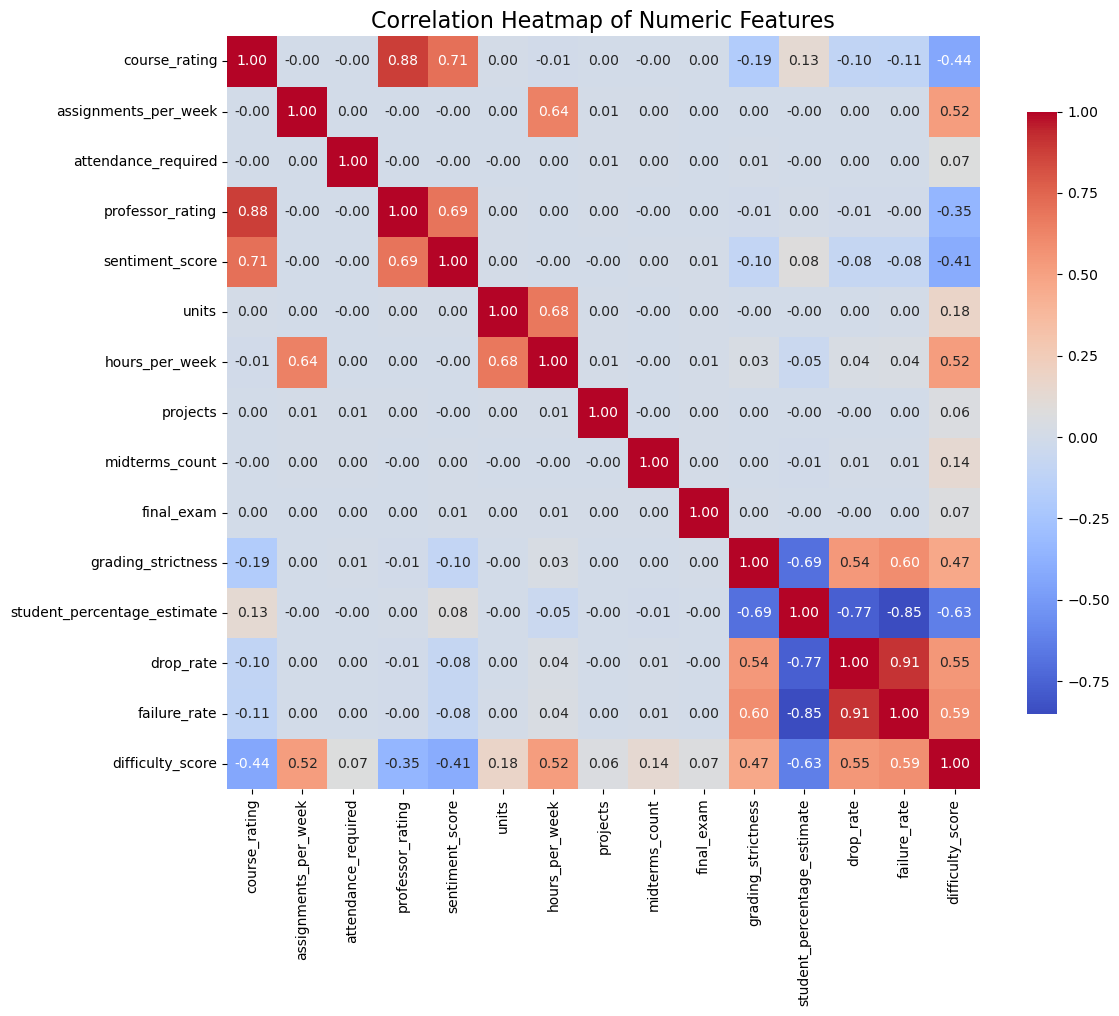

In [166]:
import seaborn as sns
import matplotlib.pyplot as plt
numeric_df = df.select_dtypes(include=[np.number])

# Compute correlation matrix
correlation_matrix = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", square=True, cbar_kws={"shrink": .8})
plt.title("Correlation Heatmap of Numeric Features", fontsize=16)
plt.tight_layout()
plt.show()

We are using boxplots to visualize how key features like grading strictness, hours per week, student performance, and difficulty score vary across different subject areas. This helps us compare the distributions and spot trends or differences between STEM, Humanities, and Social Science courses.

In [168]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

def plot_boxplot_grid(df, features, group_by, title="Boxplot Grid by Group"):
    """
    Plots boxplots of multiple features against a grouping variable in a grid layout.

    Parameters:
    - df (DataFrame): The dataset
    - features (list of str): List of numeric features to plot
    - group_by (str): Categorical column to group by on x-axis
    - title (str): Super title for the entire grid
    """
    n_cols = 2
    n_rows = math.ceil(len(features) / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
    axes = axes.flatten()

    for i, feature in enumerate(features):
        sns.boxplot(x=group_by, y=feature, data=df, ax=axes[i])
        axes[i].set_title(f"{feature.replace('_', ' ').title()} by {group_by.replace('_', ' ').title()}")
        axes[i].set_xlabel(group_by.replace('_', ' ').title())
        axes[i].set_ylabel(feature.replace('_', ' ').title())

    # Hide any extra axes
    for j in range(len(features), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.suptitle(title, fontsize=18, y=1.02)
    plt.show()


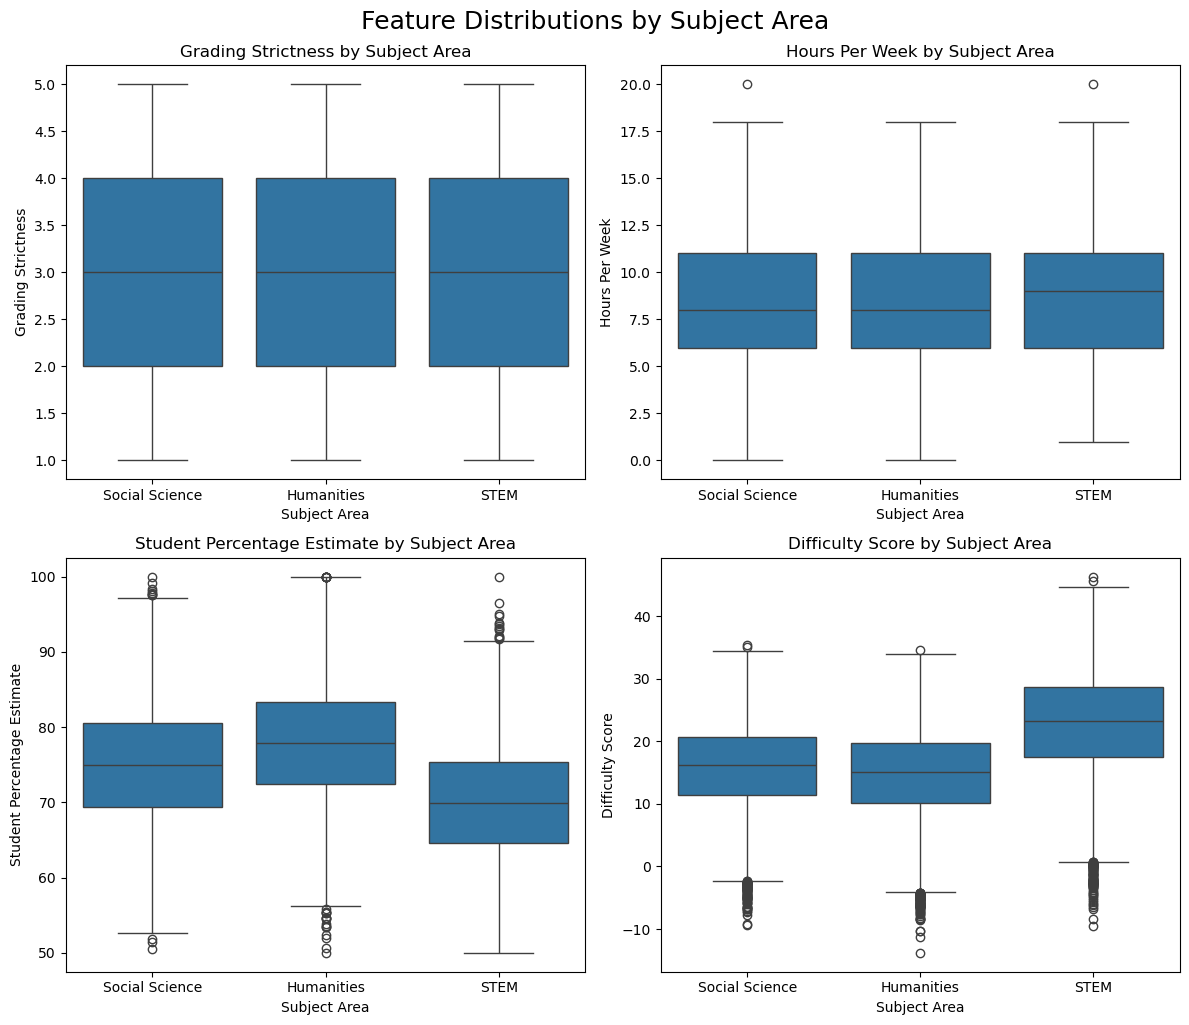

In [169]:
# features = ['grading_strictness', 'hours_per_week', 'student_percentage_estimate', 'difficulty_score']
# for feature in features:
#     plt.figure(figsize=(8, 5))
#     sns.boxplot(x='subject_area', y=feature, data=df)
#     plt.title(f"{feature.replace('_', ' ').title()} by Subject Area")
#     plt.tight_layout()
#     plt.show()


# import matplotlib.pyplot as plt
# import seaborn as sns

# features = ['grading_strictness', 'hours_per_week', 'student_percentage_estimate', 'difficulty_score']

# # Grid layout
# n_cols = 2
# n_rows = -(-len(features) // n_cols)  # Ceiling division

# fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
# axes = axes.flatten()

# for i, feature in enumerate(features):
#     sns.boxplot(x='subject_area', y=feature, data=df, ax=axes[i])
#     axes[i].set_title(f"{feature.replace('_', ' ').title()} by Subject Area")
#     axes[i].set_xlabel("Subject Area")
#     axes[i].set_ylabel(feature.replace('_', ' ').title())

# # Hide unused axes
# for j in range(i + 1, len(axes)):
#     axes[j].axis('off')

# plt.tight_layout()
# plt.suptitle("Feature Distributions by Subject Area", fontsize=18, y=1.02)
# plt.show()

features = ['grading_strictness', 'hours_per_week', 'student_percentage_estimate', 'difficulty_score']
plot_boxplot_grid(df, features, group_by='subject_area', title="Feature Distributions by Subject Area")


This helps identify whether STEM, Humanities, or Social Science courses have significantly different grading patterns, workload, or perceived difficulty.
Notably, STEM courses show higher difficulty scores and lower student performance estimates, supporting expected trends.

## Corrupting of Data

We are simulating real-world data imperfections by randomly introducing missing values in 1% of the rows for each selected column. This allows us to prepare the dataset for data wrangling and cleaning tasks commonly encountered in practical data science workflows.

In [176]:
# Load the clean dataset
corrupted_df = pd.read_csv("course_difficulty_dataset.csv")

# Make the data "dirty" for wrangling tasks

# 1. Introduce missing values randomly (10% of values in selected columns)
cols_with_missing = df.columns.tolist()
cols_with_missing.remove("difficulty_score")
cols_with_missing.remove("difficulty_level")
for col in cols_with_missing:
    corrupted_df.loc[corrupted_df.sample(frac=0.01).index, col] = np.nan

We are introducing additional extreme outliers (in addition to the ones we added manually above) to simulate corrupted or unrealistic entries in the dataset. This includes inflating values like hours per week, student percentage estimates, course ratings, professor ratings, and grading strictness well beyond their normal ranges. These outliers help test the robustness of future cleaning and preprocessing steps.

In [181]:
# 2. Introduce extreme outliers artificially in addition to the ones we added above
corrupted_df.loc[corrupted_df.sample(frac=0.001).index, 'hours_per_week'] *= 3  # unrealistic time requirement
corrupted_df.loc[corrupted_df.sample(frac=0.001).index, 'student_percentage_estimate'] *= 1.5  # impossible percentage
corrupted_df.loc[corrupted_df.sample(frac=0.001).index, 'professor_rating'] *= 2
corrupted_df.loc[corrupted_df.sample(frac=0.001).index, 'grading_strictness'] *= 3
corrupted_df

course_rating  assignments_per_week  attendance_required  \
0                4.2                   0.0                  0.0   
1                2.2                   1.0                  1.0   
2                2.6                   3.0                  1.0   
3                1.5                   2.0                  0.0   
4                1.9                   5.0                  1.0   
...              ...                   ...                  ...   
50005            2.0                   1.0                  0.0   
50006            3.0                   0.0                  1.0   
50007            5.0                   3.0                  1.0   
50008            1.0                   1.0                  1.0   
50009            3.0                   2.0                  1.0   

       professor_rating  sentiment_score    subject_area  units  \
0                   4.0             1.00  Social Science    6.0   
1                   3.0            -0.71  Social Science    9.0   
2                   3.0            -0.26      Humanities    9.0   
3                   2.0            -0.89            STEM    9.0   
4                   2.0             0.43  Social Science   12.0   
...                 ...              ...             ...    ...   
50005               3.0            -0.30      Humanities    3.0   
50006               4.0             0.20            STEM    6.0   
50007               5.0            -1.00            STEM   12.0   
50008               5.0            -0.50            STEM    6.0   
50009               3.5             0.00  Social Science    3.0   

       hours_per_week  projects  midterms_count  final_exam  \
0                 4.0       0.0             1.0         1.0   
1                 6.0       1.0             1.0         0.0   
2                 NaN       0.0             0.0         0.0   
3                 9.0       0.0             2.0         0.0   
4                14.0       1.0             2.0         1.0   
...               ...       ...             ...         ...   
50005             5.0       0.0             0.0         1.0   
50006            20.0       1.0             1.0         1.0   
50007            15.0       1.0             2.0         1.0   
50008             8.0       0.0             1.0         1.0   
50009            20.0       1.0             1.0         1.0   

       grading_strictness  student_percentage_estimate  drop_rate  \
0                     1.7                         80.6       0.14   
1                     4.2                         66.5       0.20   
2                     2.6                         80.7       0.14   
3                     1.2                         81.0       0.07   
4                     1.5                         88.7       0.06   
...                   ...                          ...        ...   
50005                 5.0                         60.0       0.10   
50006                 3.0                         80.0       0.05   
50007                 3.5                         90.0       0.05   
50008                 4.0                         70.0       0.20   
50009                 3.0                         75.0       0.10   

       failure_rate  difficulty_score difficulty_level  
0              0.12         -0.239720             Easy  
1              0.29         16.345990           Medium  
2              0.21         12.477249             Easy  
3              0.14         17.988776           Medium  
4               NaN         18.274062           Medium  
...             ...               ...              ...  
50005          0.30         14.113071           Medium  
50006          0.10         17.078283           Medium  
50007          0.05         17.821790           Medium  
50008          0.20         20.074865             Hard  
50009          0.20         22.479648             Hard  

[50010 rows x 17 columns]

In [183]:
# Save this dirty version to a new CSV
corrupted_df.to_csv("dirty_course_difficulty_dataset.csv", index=False)

corrupted_df.head()
corrupted_df

course_rating  assignments_per_week  attendance_required  \
0                4.2                   0.0                  0.0   
1                2.2                   1.0                  1.0   
2                2.6                   3.0                  1.0   
3                1.5                   2.0                  0.0   
4                1.9                   5.0                  1.0   
...              ...                   ...                  ...   
50005            2.0                   1.0                  0.0   
50006            3.0                   0.0                  1.0   
50007            5.0                   3.0                  1.0   
50008            1.0                   1.0                  1.0   
50009            3.0                   2.0                  1.0   

       professor_rating  sentiment_score    subject_area  units  \
0                   4.0             1.00  Social Science    6.0   
1                   3.0            -0.71  Social Science    9.0   
2                   3.0            -0.26      Humanities    9.0   
3                   2.0            -0.89            STEM    9.0   
4                   2.0             0.43  Social Science   12.0   
...                 ...              ...             ...    ...   
50005               3.0            -0.30      Humanities    3.0   
50006               4.0             0.20            STEM    6.0   
50007               5.0            -1.00            STEM   12.0   
50008               5.0            -0.50            STEM    6.0   
50009               3.5             0.00  Social Science    3.0   

       hours_per_week  projects  midterms_count  final_exam  \
0                 4.0       0.0             1.0         1.0   
1                 6.0       1.0             1.0         0.0   
2                 NaN       0.0             0.0         0.0   
3                 9.0       0.0             2.0         0.0   
4                14.0       1.0             2.0         1.0   
...               ...       ...             ...         ...   
50005             5.0       0.0             0.0         1.0   
50006            20.0       1.0             1.0         1.0   
50007            15.0       1.0             2.0         1.0   
50008             8.0       0.0             1.0         1.0   
50009            20.0       1.0             1.0         1.0   

       grading_strictness  student_percentage_estimate  drop_rate  \
0                     1.7                         80.6       0.14   
1                     4.2                         66.5       0.20   
2                     2.6                         80.7       0.14   
3                     1.2                         81.0       0.07   
4                     1.5                         88.7       0.06   
...                   ...                          ...        ...   
50005                 5.0                         60.0       0.10   
50006                 3.0                         80.0       0.05   
50007                 3.5                         90.0       0.05   
50008                 4.0                         70.0       0.20   
50009                 3.0                         75.0       0.10   

       failure_rate  difficulty_score difficulty_level  
0              0.12         -0.239720             Easy  
1              0.29         16.345990           Medium  
2              0.21         12.477249             Easy  
3              0.14         17.988776           Medium  
4               NaN         18.274062           Medium  
...             ...               ...              ...  
50005          0.30         14.113071           Medium  
50006          0.10         17.078283           Medium  
50007          0.05         17.821790           Medium  
50008          0.20         20.074865             Hard  
50009          0.20         22.479648             Hard  

[50010 rows x 17 columns]

In [186]:
corrupted_df.isnull().sum()

course_rating                  500
assignments_per_week           500
attendance_required            500
professor_rating               500
sentiment_score                500
subject_area                   500
units                          500
hours_per_week                 500
projects                       500
midterms_count                 500
final_exam                     500
grading_strictness             500
student_percentage_estimate    500
drop_rate                      500
failure_rate                   500
difficulty_score                 0
difficulty_level                 0
dtype: int64

# D2.2 Exploratory Data Analysis

We are loading the dirty dataset, correcting any datatype issues (especially in numeric columns), and displaying the dataset's features, correlations, outliers, and distributions to see how are data actually looks like.

In [190]:
# Load the dirty dataset
df = pd.read_csv("dirty_course_difficulty_dataset.csv")

# Fix datatypes in case of string corruption
df['assignments_per_week'] = pd.to_numeric(df['assignments_per_week'], errors='coerce')

# Show shape and head
print("Dataset shape:", df.shape)
df.head()


Dataset shape: (50010, 17)


course_rating  assignments_per_week  attendance_required  professor_rating  \
0            4.2                   0.0                  0.0               4.0   
1            2.2                   1.0                  1.0               3.0   
2            2.6                   3.0                  1.0               3.0   
3            1.5                   2.0                  0.0               2.0   
4            1.9                   5.0                  1.0               2.0   

   sentiment_score    subject_area  units  hours_per_week  projects  \
0             1.00  Social Science    6.0             4.0       0.0   
1            -0.71  Social Science    9.0             6.0       1.0   
2            -0.26      Humanities    9.0             NaN       0.0   
3            -0.89            STEM    9.0             9.0       0.0   
4             0.43  Social Science   12.0            14.0       1.0   

   midterms_count  final_exam  grading_strictness  \
0             1.0         1.0                 1.7   
1             1.0         0.0                 4.2   
2             0.0         0.0                 2.6   
3             2.0         0.0                 1.2   
4             2.0         1.0                 1.5   

   student_percentage_estimate  drop_rate  failure_rate  difficulty_score  \
0                         80.6       0.14          0.12         -0.239720   
1                         66.5       0.20          0.29         16.345990   
2                         80.7       0.14          0.21         12.477249   
3                         81.0       0.07          0.14         17.988776   
4                         88.7       0.06           NaN         18.274062   

  difficulty_level  
0             Easy  
1           Medium  
2             Easy  
3           Medium  
4           Medium

In [192]:
# General info
df.info()

# Data types summary
df.dtypes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50010 entries, 0 to 50009
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   course_rating                49510 non-null  float64
 1   assignments_per_week         49510 non-null  float64
 2   attendance_required          49510 non-null  float64
 3   professor_rating             49510 non-null  float64
 4   sentiment_score              49510 non-null  float64
 5   subject_area                 49510 non-null  object 
 6   units                        49510 non-null  float64
 7   hours_per_week               49510 non-null  float64
 8   projects                     49510 non-null  float64
 9   midterms_count               49510 non-null  float64
 10  final_exam                   49510 non-null  float64
 11  grading_strictness           49510 non-null  float64
 12  student_percentage_estimate  49510 non-null  float64
 13  drop_rate       

course_rating                  float64
assignments_per_week           float64
attendance_required            float64
professor_rating               float64
sentiment_score                float64
subject_area                    object
units                          float64
hours_per_week                 float64
projects                       float64
midterms_count                 float64
final_exam                     float64
grading_strictness             float64
student_percentage_estimate    float64
drop_rate                      float64
failure_rate                   float64
difficulty_score               float64
difficulty_level                object
dtype: object

In [194]:
# Count missing values
missing = df.isnull().sum()
missing

course_rating                  500
assignments_per_week           500
attendance_required            500
professor_rating               500
sentiment_score                500
subject_area                   500
units                          500
hours_per_week                 500
projects                       500
midterms_count                 500
final_exam                     500
grading_strictness             500
student_percentage_estimate    500
drop_rate                      500
failure_rate                   500
difficulty_score                 0
difficulty_level                 0
dtype: int64

In [196]:
# Displaying the categorical columns
cat_cols = df.select_dtypes(include='object').columns.tolist()
for col in cat_cols:
    print(f"\n{col}:", df[col].unique())



subject_area: ['Social Science' 'Humanities' 'STEM' nan]

difficulty_level: ['Easy' 'Medium' 'Hard']


In [198]:
# Summary for numeric and categorical features
df.describe(include='all').T


count unique     top   freq       mean  \
course_rating                49510.0    NaN     NaN    NaN   2.352268   
assignments_per_week         49510.0    NaN     NaN    NaN    2.49186   
attendance_required          49510.0    NaN     NaN    NaN   0.503918   
professor_rating             49510.0    NaN     NaN    NaN   2.846385   
sentiment_score              49510.0    NaN     NaN    NaN  -0.238269   
subject_area                   49510      3    STEM  16601        NaN   
units                        49510.0    NaN     NaN    NaN   7.637427   
hours_per_week               49510.0    NaN     NaN    NaN   8.497172   
projects                     49510.0    NaN     NaN    NaN    0.49899   
midterms_count               49510.0    NaN     NaN    NaN   1.001414   
final_exam                   49510.0    NaN     NaN    NaN   0.498768   
grading_strictness           49510.0    NaN     NaN    NaN   3.006193   
student_percentage_estimate  49510.0    NaN     NaN    NaN  74.305156   
drop_rate                    49510.0    NaN     NaN    NaN   0.177803   
failure_rate                 49510.0    NaN     NaN    NaN   0.254327   
difficulty_score             50010.0    NaN     NaN    NaN  17.850473   
difficulty_level               50010      3  Medium  25005        NaN   

                                  std        min        25%        50%  \
course_rating                1.061965        1.0        1.4        2.3   
assignments_per_week         1.704907        0.0        1.0        2.0   
attendance_required           0.49999        0.0        0.0        1.0   
professor_rating             1.111749        1.0        2.0        3.0   
sentiment_score              0.608223       -1.0       -0.8       -0.3   
subject_area                      NaN        NaN        NaN        NaN   
units                        3.219126        3.0        3.0        9.0   
hours_per_week               3.358209        0.0        6.0        8.0   
projects                     0.500004        0.0        0.0        0.0   
midterms_count               0.818077        0.0        0.0        1.0   
final_exam                   0.500004        0.0        0.0        0.0   
grading_strictness           1.172944        1.0        2.0        3.0   
student_percentage_estimate  8.372437       50.0       68.4       74.2   
drop_rate                    0.069643        0.0       0.13       0.18   
failure_rate                  0.09147        0.0       0.19       0.26   
difficulty_score             8.158371 -13.816594  12.351053  17.776792   
difficulty_level                  NaN        NaN        NaN        NaN   

                                   75%        max  
course_rating                      3.1        5.0  
assignments_per_week               4.0        5.0  
attendance_required                1.0        1.0  
professor_rating                   4.0       10.0  
sentiment_score                   0.21        1.0  
subject_area                       NaN        NaN  
units                              9.0       12.0  
hours_per_week                    11.0       42.0  
projects                           1.0        1.0  
midterms_count                     2.0        2.0  
final_exam                         1.0        1.0  
grading_strictness                 4.0       14.7  
student_percentage_estimate       80.2     139.35  
drop_rate                         0.23        0.3  
failure_rate                      0.32        0.4  
difficulty_score             23.278714  46.320967  
difficulty_level                   NaN        NaN

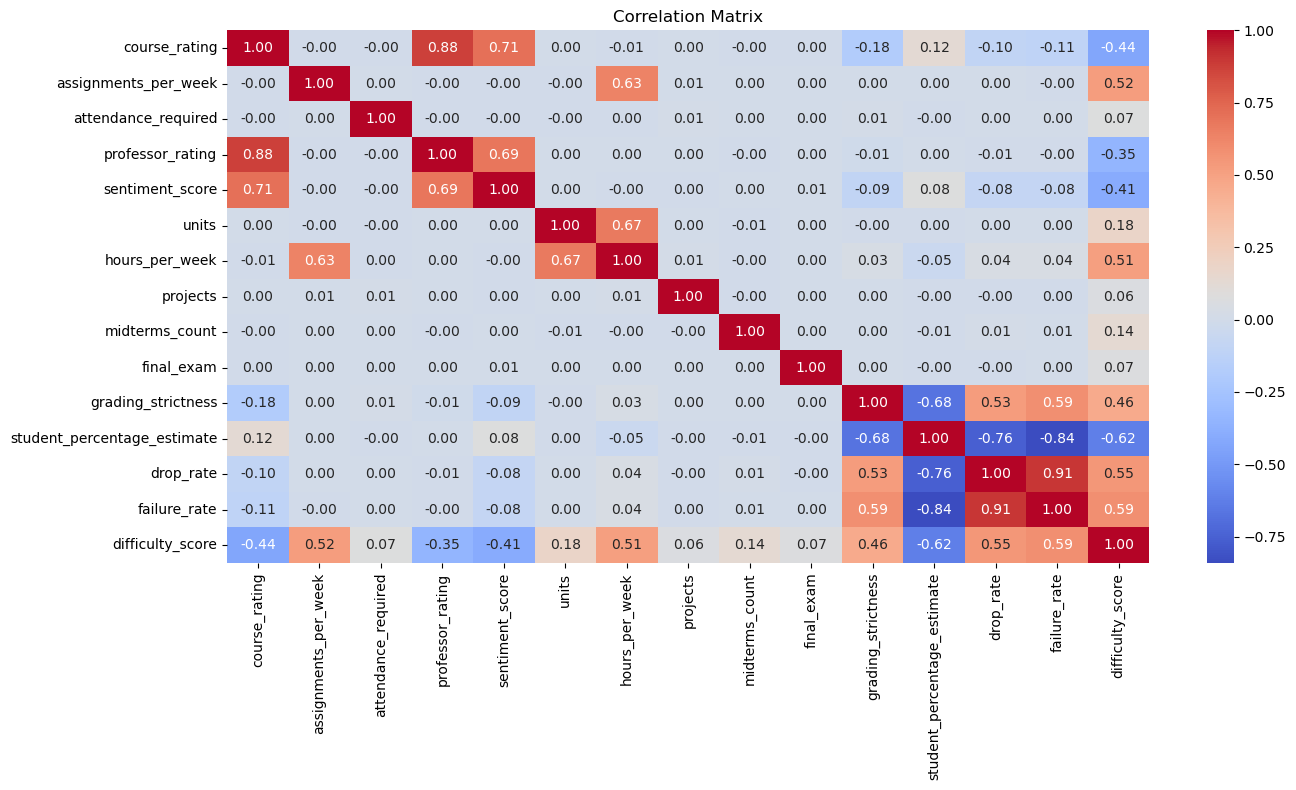

In [200]:
# visualizing the correlations between numeric features to identify patterns and potential data issues.
plt.figure(figsize=(14, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()


We are plotting the distributions of key numeric features to visually inspect their spread, identify skewness in the dataset.

In [203]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

def plot_histogram_grid(df, features, title="Histogram Grid of Features", bins=30):
    """
    Plots histograms (with KDE) for a list of numeric features in a grid layout.

    Parameters:
    - df (DataFrame): The dataset
    - features (list of str): List of numeric feature names
    - title (str): Supertitle for the whole grid
    - bins (int): Number of histogram bins
    """
    n_cols = 3
    n_rows = math.ceil(len(features) / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))
    axes = axes.flatten()

    for i, col in enumerate(features):
        sns.histplot(df[col], kde=True, bins=bins, ax=axes[i])
        axes[i].set_title(f"Distribution of {col}")
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("Frequency")

    # Hide unused axes
    for j in range(len(features), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.suptitle(title, fontsize=18, y=1.02)
    plt.show()


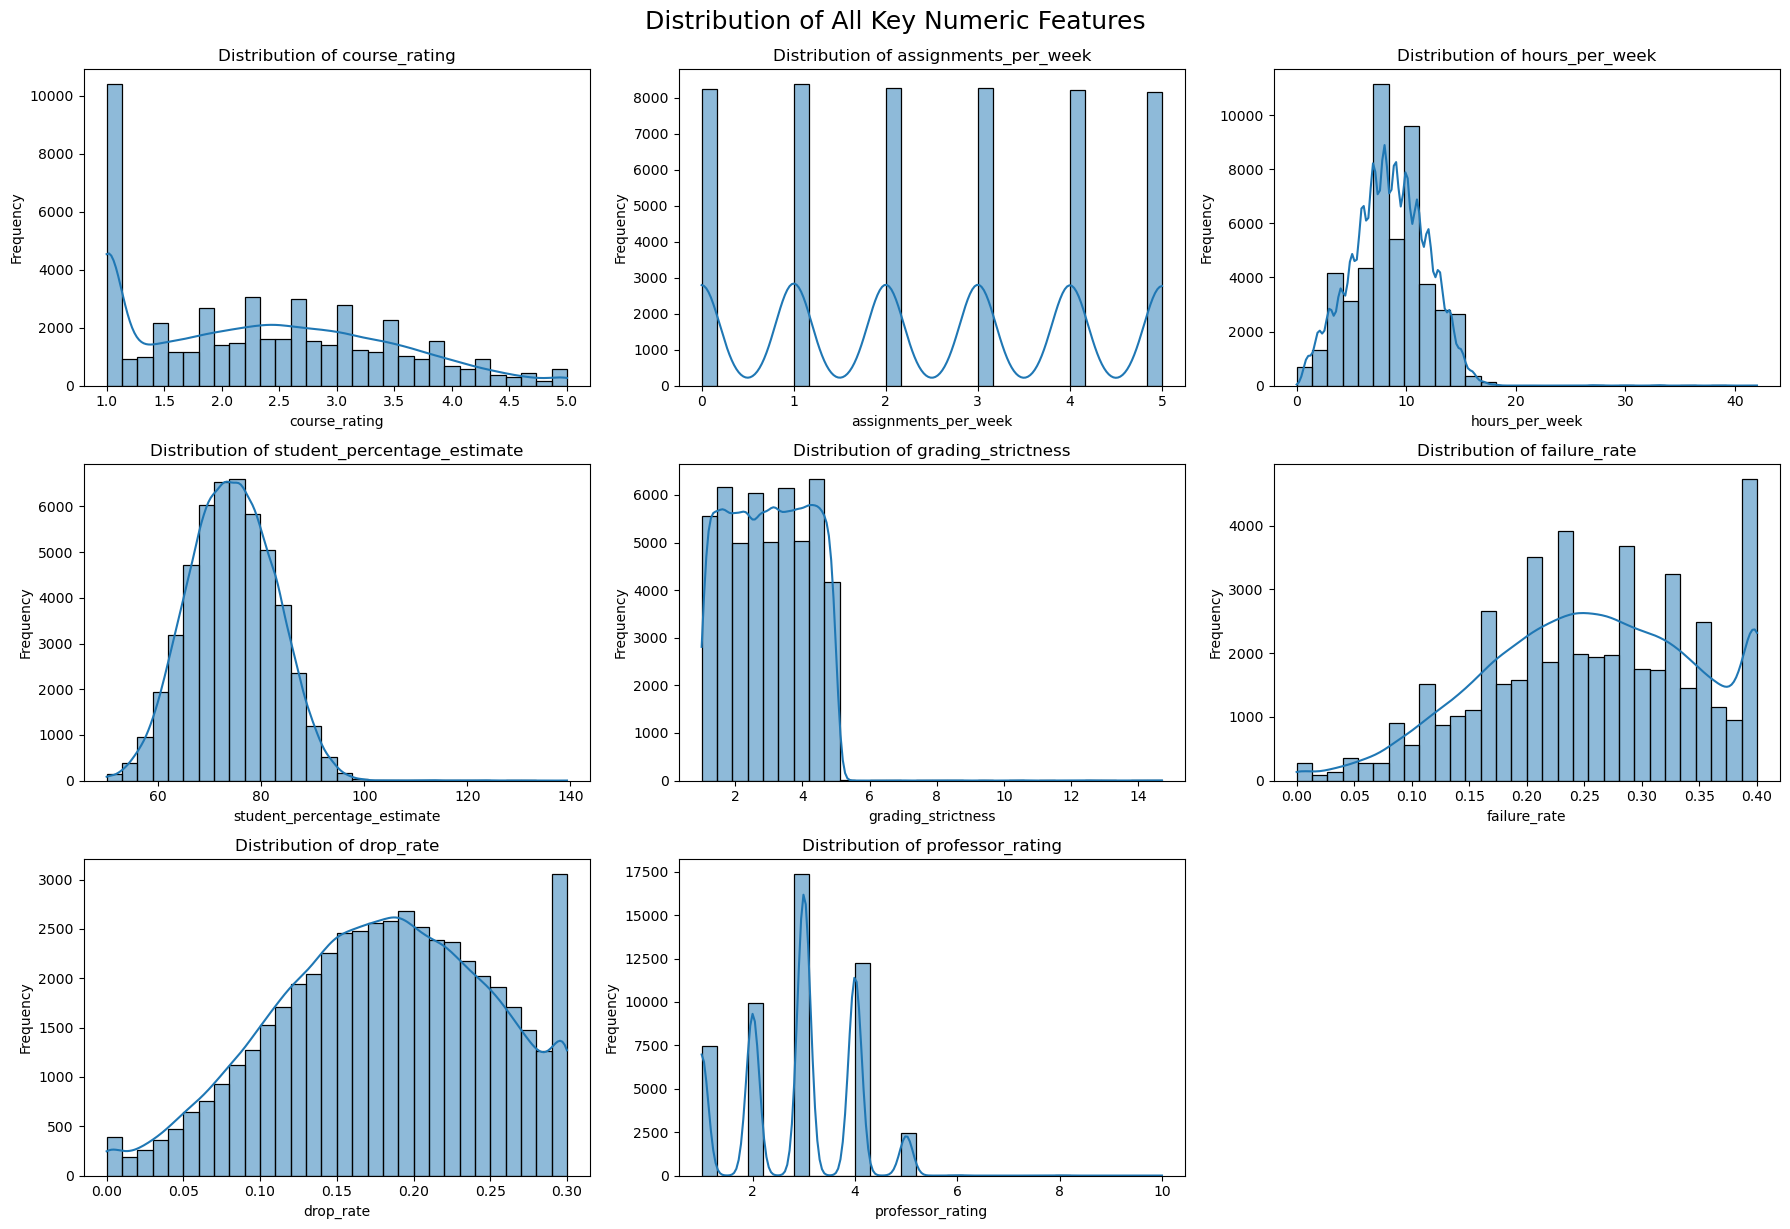

In [205]:
numeric_cols = ['course_rating', 'assignments_per_week', 'hours_per_week',
                'student_percentage_estimate', 'grading_strictness',
                'failure_rate', 'drop_rate', 'professor_rating']

plot_histogram_grid(df, numeric_cols, title="Distribution of All Key Numeric Features")

We plot the distributions of major numeric features in a grid to understand the spread, shape, and presence of outliers in each. This guides data wrangling, transformation, and feature scaling decisions.

- **`course_rating`** and **`professor_rating`** are right-skewed, with many students giving lower scores, which may reflect dissatisfaction or stricter grading.
- **`assignments_per_week`** shows a multimodal distribution due to its integer nature (0–5).
- **`hours_per_week`** is roughly bell-shaped but slightly skewed, likely reflecting course type variation.
- **`student_percentage_estimate`** is close to a normal distribution, suggesting reliable use for modeling.
- **`grading_strictness`**, **`failure_rate`**, and **`drop_rate`** show non-normal distributions with possible outliers, highlighting where IQR-based filtering or robust scaling may be appropriate.


We are using boxplots to detect outliers and understand the range and central tendency of each numeric feature in the dataset.

In [208]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

def plot_boxplot_matrix(df, features, title="Boxplot Matrix of Features"):
    """
    Plots simple boxplots (not grouped) for multiple features in a grid layout.

    Parameters:
    - df (DataFrame): The dataset
    - features (list of str): Numeric features to plot
    - title (str): Grid supertitle
    """
    n_cols = 3
    n_rows = math.ceil(len(features) / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 3.5 * n_rows))
    axes = axes.flatten()

    for i, col in enumerate(features):
        sns.boxplot(x=df[col], ax=axes[i])
        axes[i].set_title(f"Boxplot of {col}")
        axes[i].set_xlabel(col)

    for j in range(len(features), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.suptitle(title, fontsize=16, y=1.02)
    plt.show()

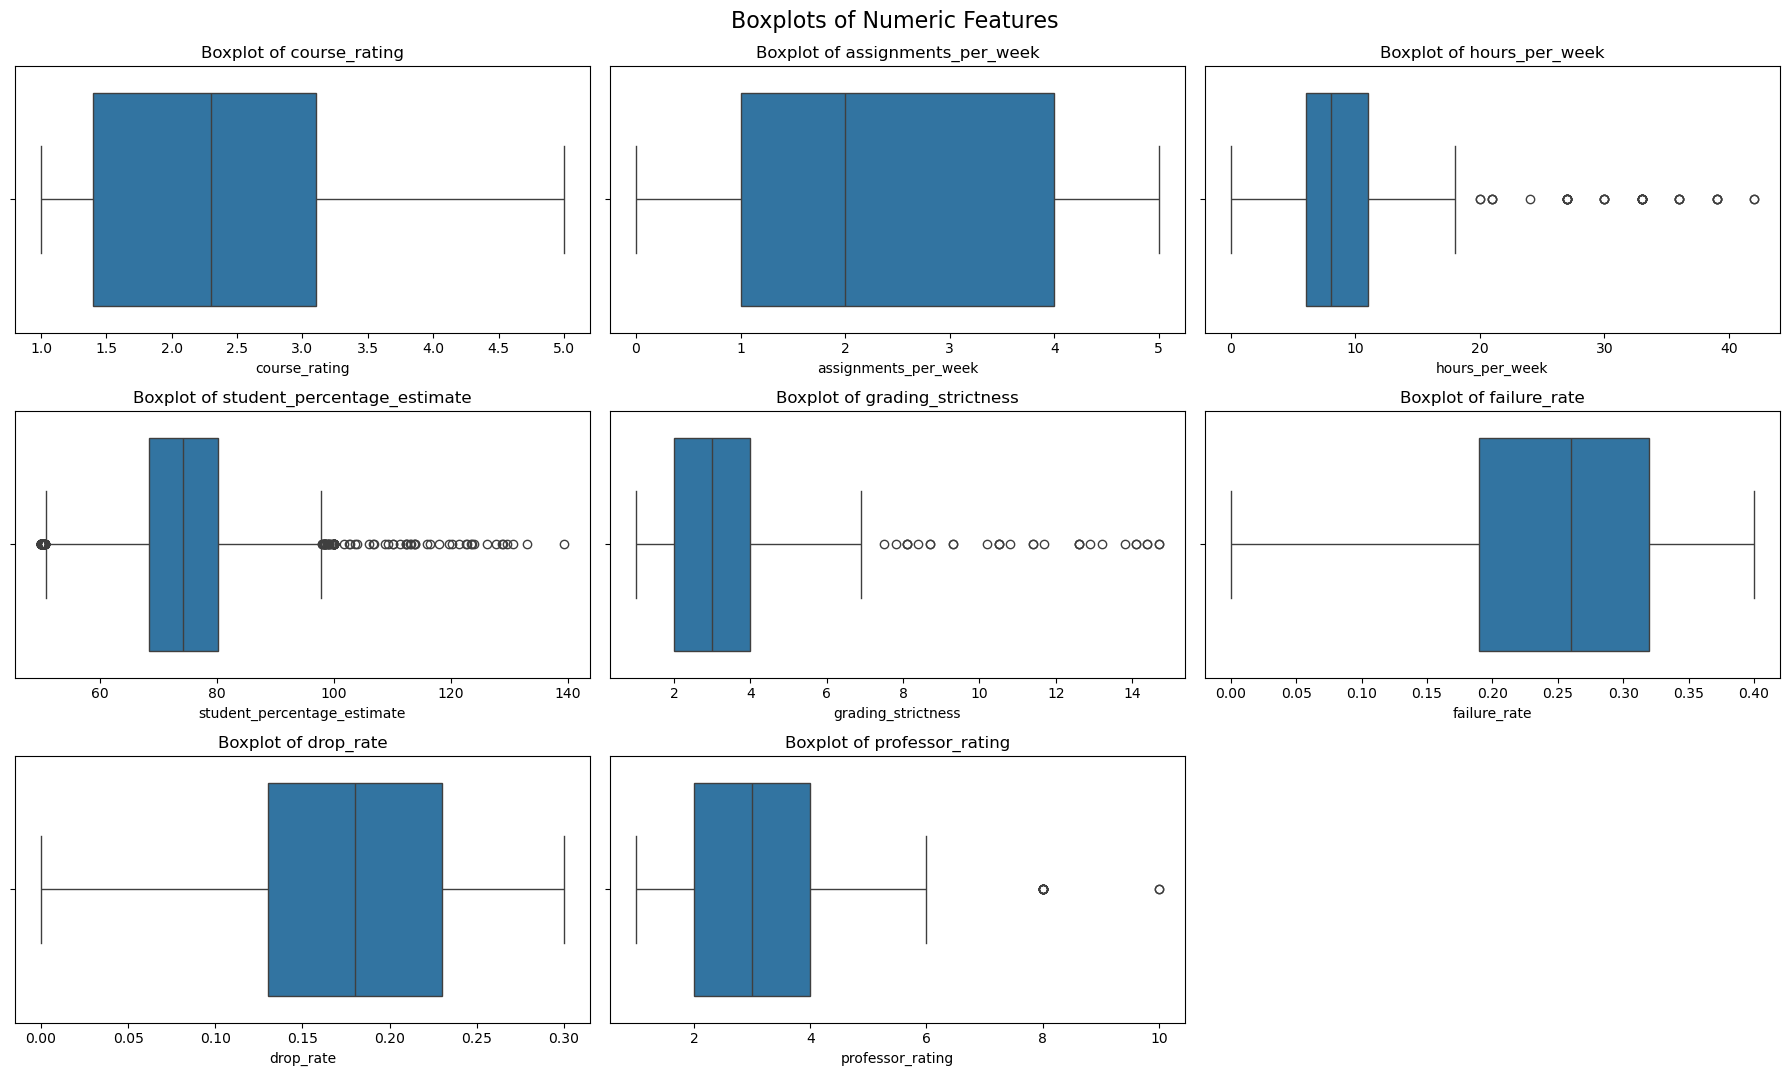

In [209]:
plot_boxplot_matrix(df, numeric_cols, title="Boxplots of Numeric Features")


We use boxplots to visualize the spread and presence of outliers in each numeric variable. This is useful for identifying skewed distributions and deciding where outlier treatment or scaling is needed.

- **`hours_per_week`** and **`grading_strictness`** show several outliers, suggesting variation in course structure or inconsistent rating behavior.
- **`student_percentage_estimate`** and **`drop_rate`** reveal long tails on the right, supporting the decision to clip or robustly scale these features.
- **`failure_rate`** appears more balanced but still contains mild extremes.
- **Overall**, these plots confirm that many features are non-normally distributed with outliers.

We are visualizing how each numeric feature varies across difficulty levels to explore potential patterns or differences between Easy, Medium, and Hard courses.

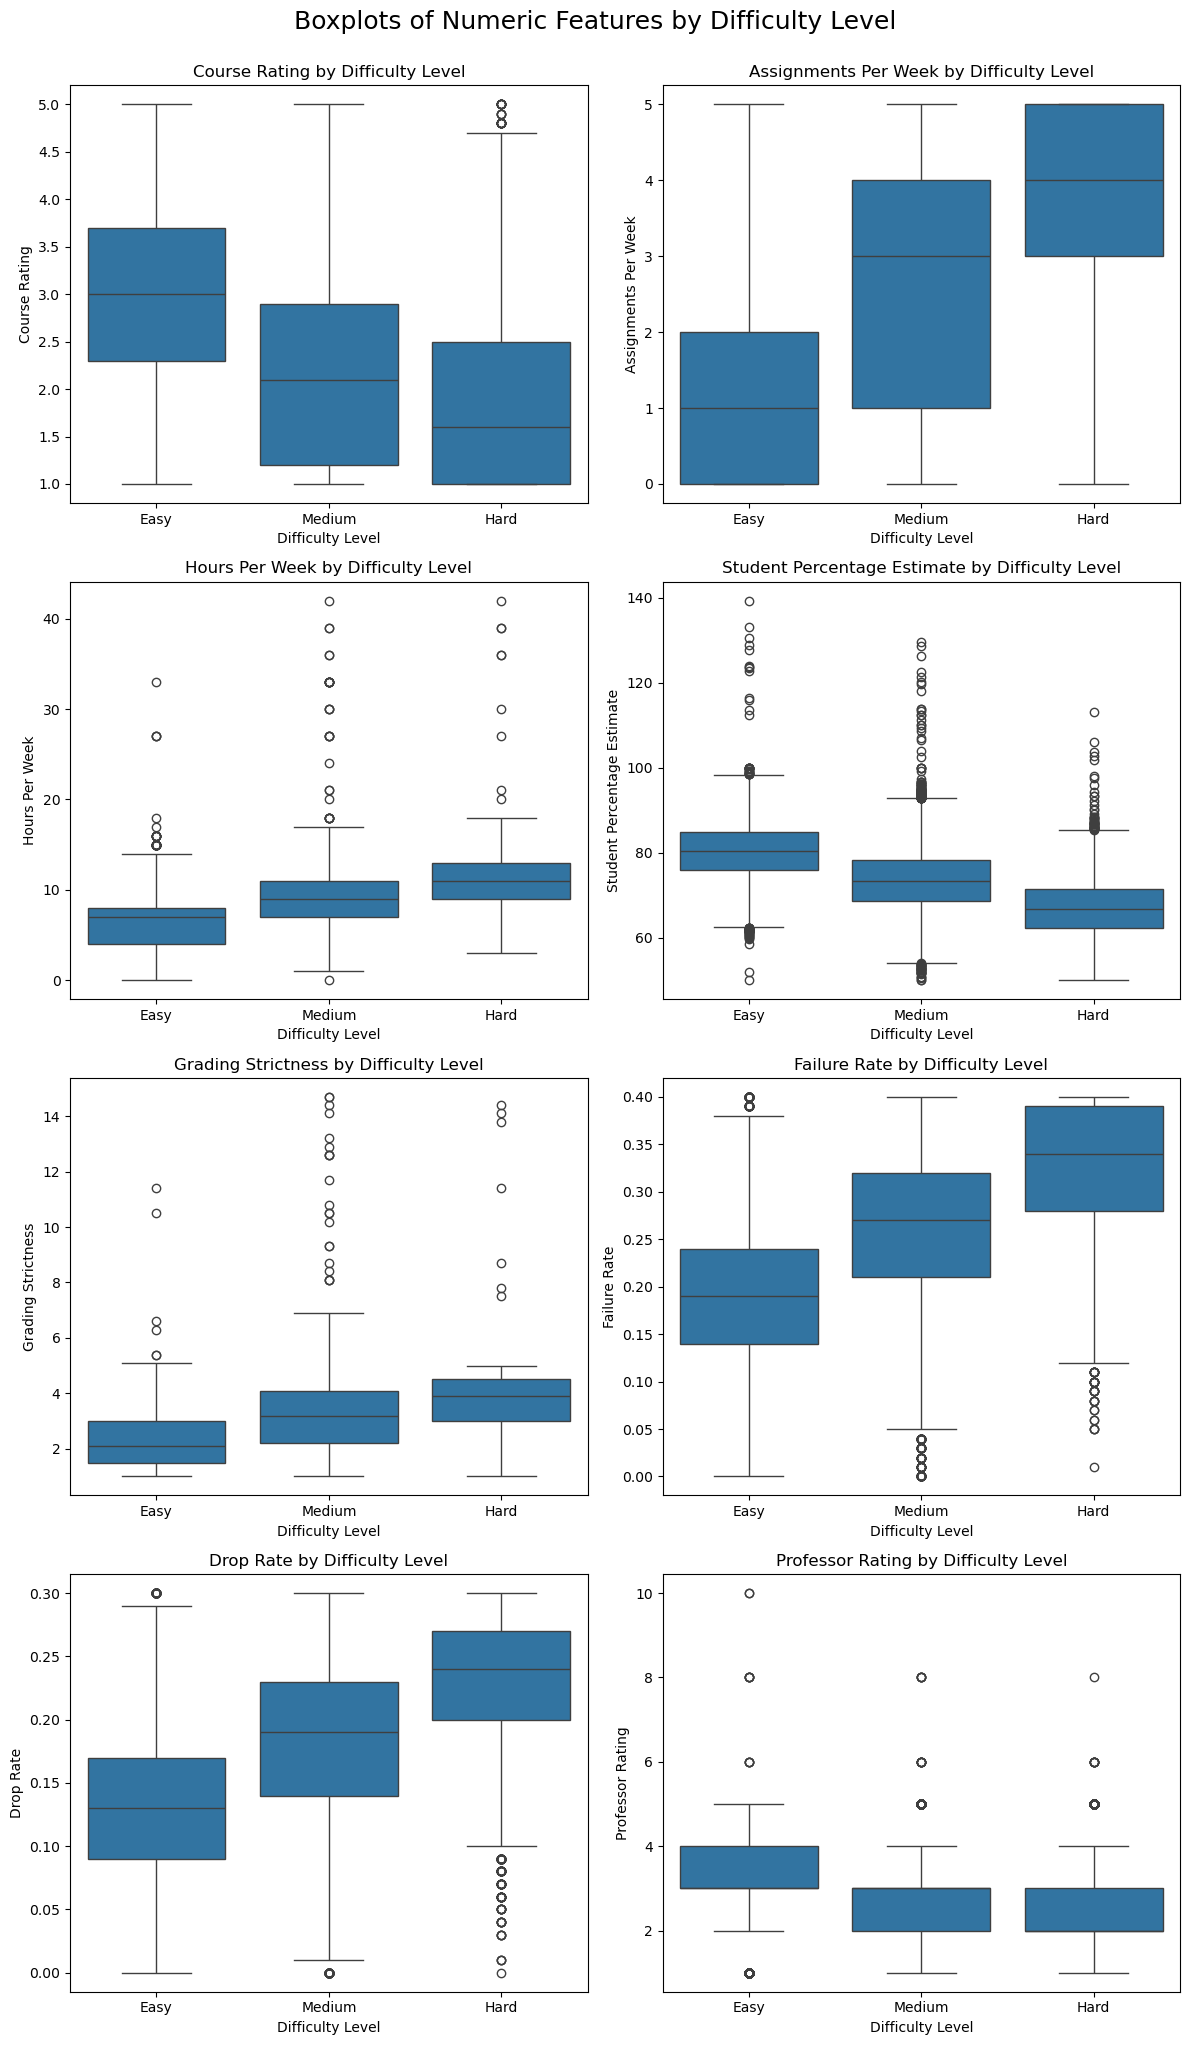

In [212]:
plot_boxplot_grid(
    df=df,
    features=numeric_cols,
    group_by='difficulty_level',
    title="Boxplots of Numeric Features by Difficulty Level"
)


This visualization compares key numeric features across three course difficulty levels (Easy, Medium, Hard). These insights help us understand how specific course characteristics influence perceived difficulty:

- **Course Rating** tends to decline as difficulty increases, suggesting students rate harder courses more negatively.
- **Assignments and Hours per Week** both rise consistently with difficulty, which validates our scoring logic.
- **Student Percentage Estimate** decreases as difficulty increases, students perceive harder courses as more challenging and tend to score lower.
- **Grading Strictness**, **Failure Rate**, and **Drop Rate** are all elevated for harder courses, confirming that difficulty labels align with more demanding academic conditions.

These patterns validate that our target variable is meaningfully structured and that engineered features reflect real differences between course types.

--------------------------

We are plotting the frequency of each category in subject_area and difficulty_level to understand the class distribution and detect any imbalance in the dataset.
These count plots help us assess class balance in two key categorical variables:

- **Subject Area**: The dataset is well-balanced across STEM, Humanities, and Social Science courses, each contributing roughly equally to the sample. This helps avoid subject-related bias during training.

- **Difficulty Level**: The distribution follows a 40-30-30 strategy, with Medium courses being the most frequent, followed by Easy and Hard. This was an intentional choice during generation to ensure slight overrepresentation of harder courses for meaningful difficulty modeling.

Understanding these distributions ensures that our models are not skewed by class imbalance and gives confidence in the representativeness of our training data.

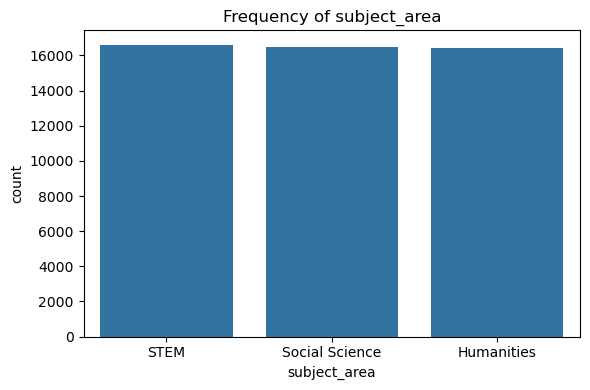

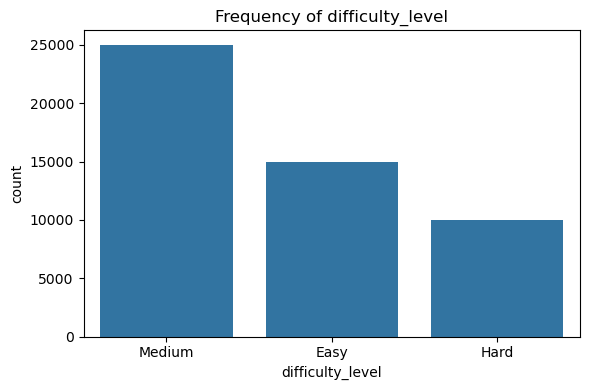

In [218]:
categorical_cols = ['subject_area', 'difficulty_level']
for col in categorical_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.title(f"Frequency of {col}")
    plt.tight_layout()
    plt.show()


We are generating a pairplot of numeric features, colored by difficulty level, to visualize relationships between variables and observe how Easy, Medium, and Hard courses cluster across different feature combinations.

In [222]:
# Select only numeric columns and drop rows with missing values to avoid errors
numeric_df = df.select_dtypes(include='number').copy()
numeric_df['difficulty_level'] = df['difficulty_level']
numeric_df = numeric_df.dropna()

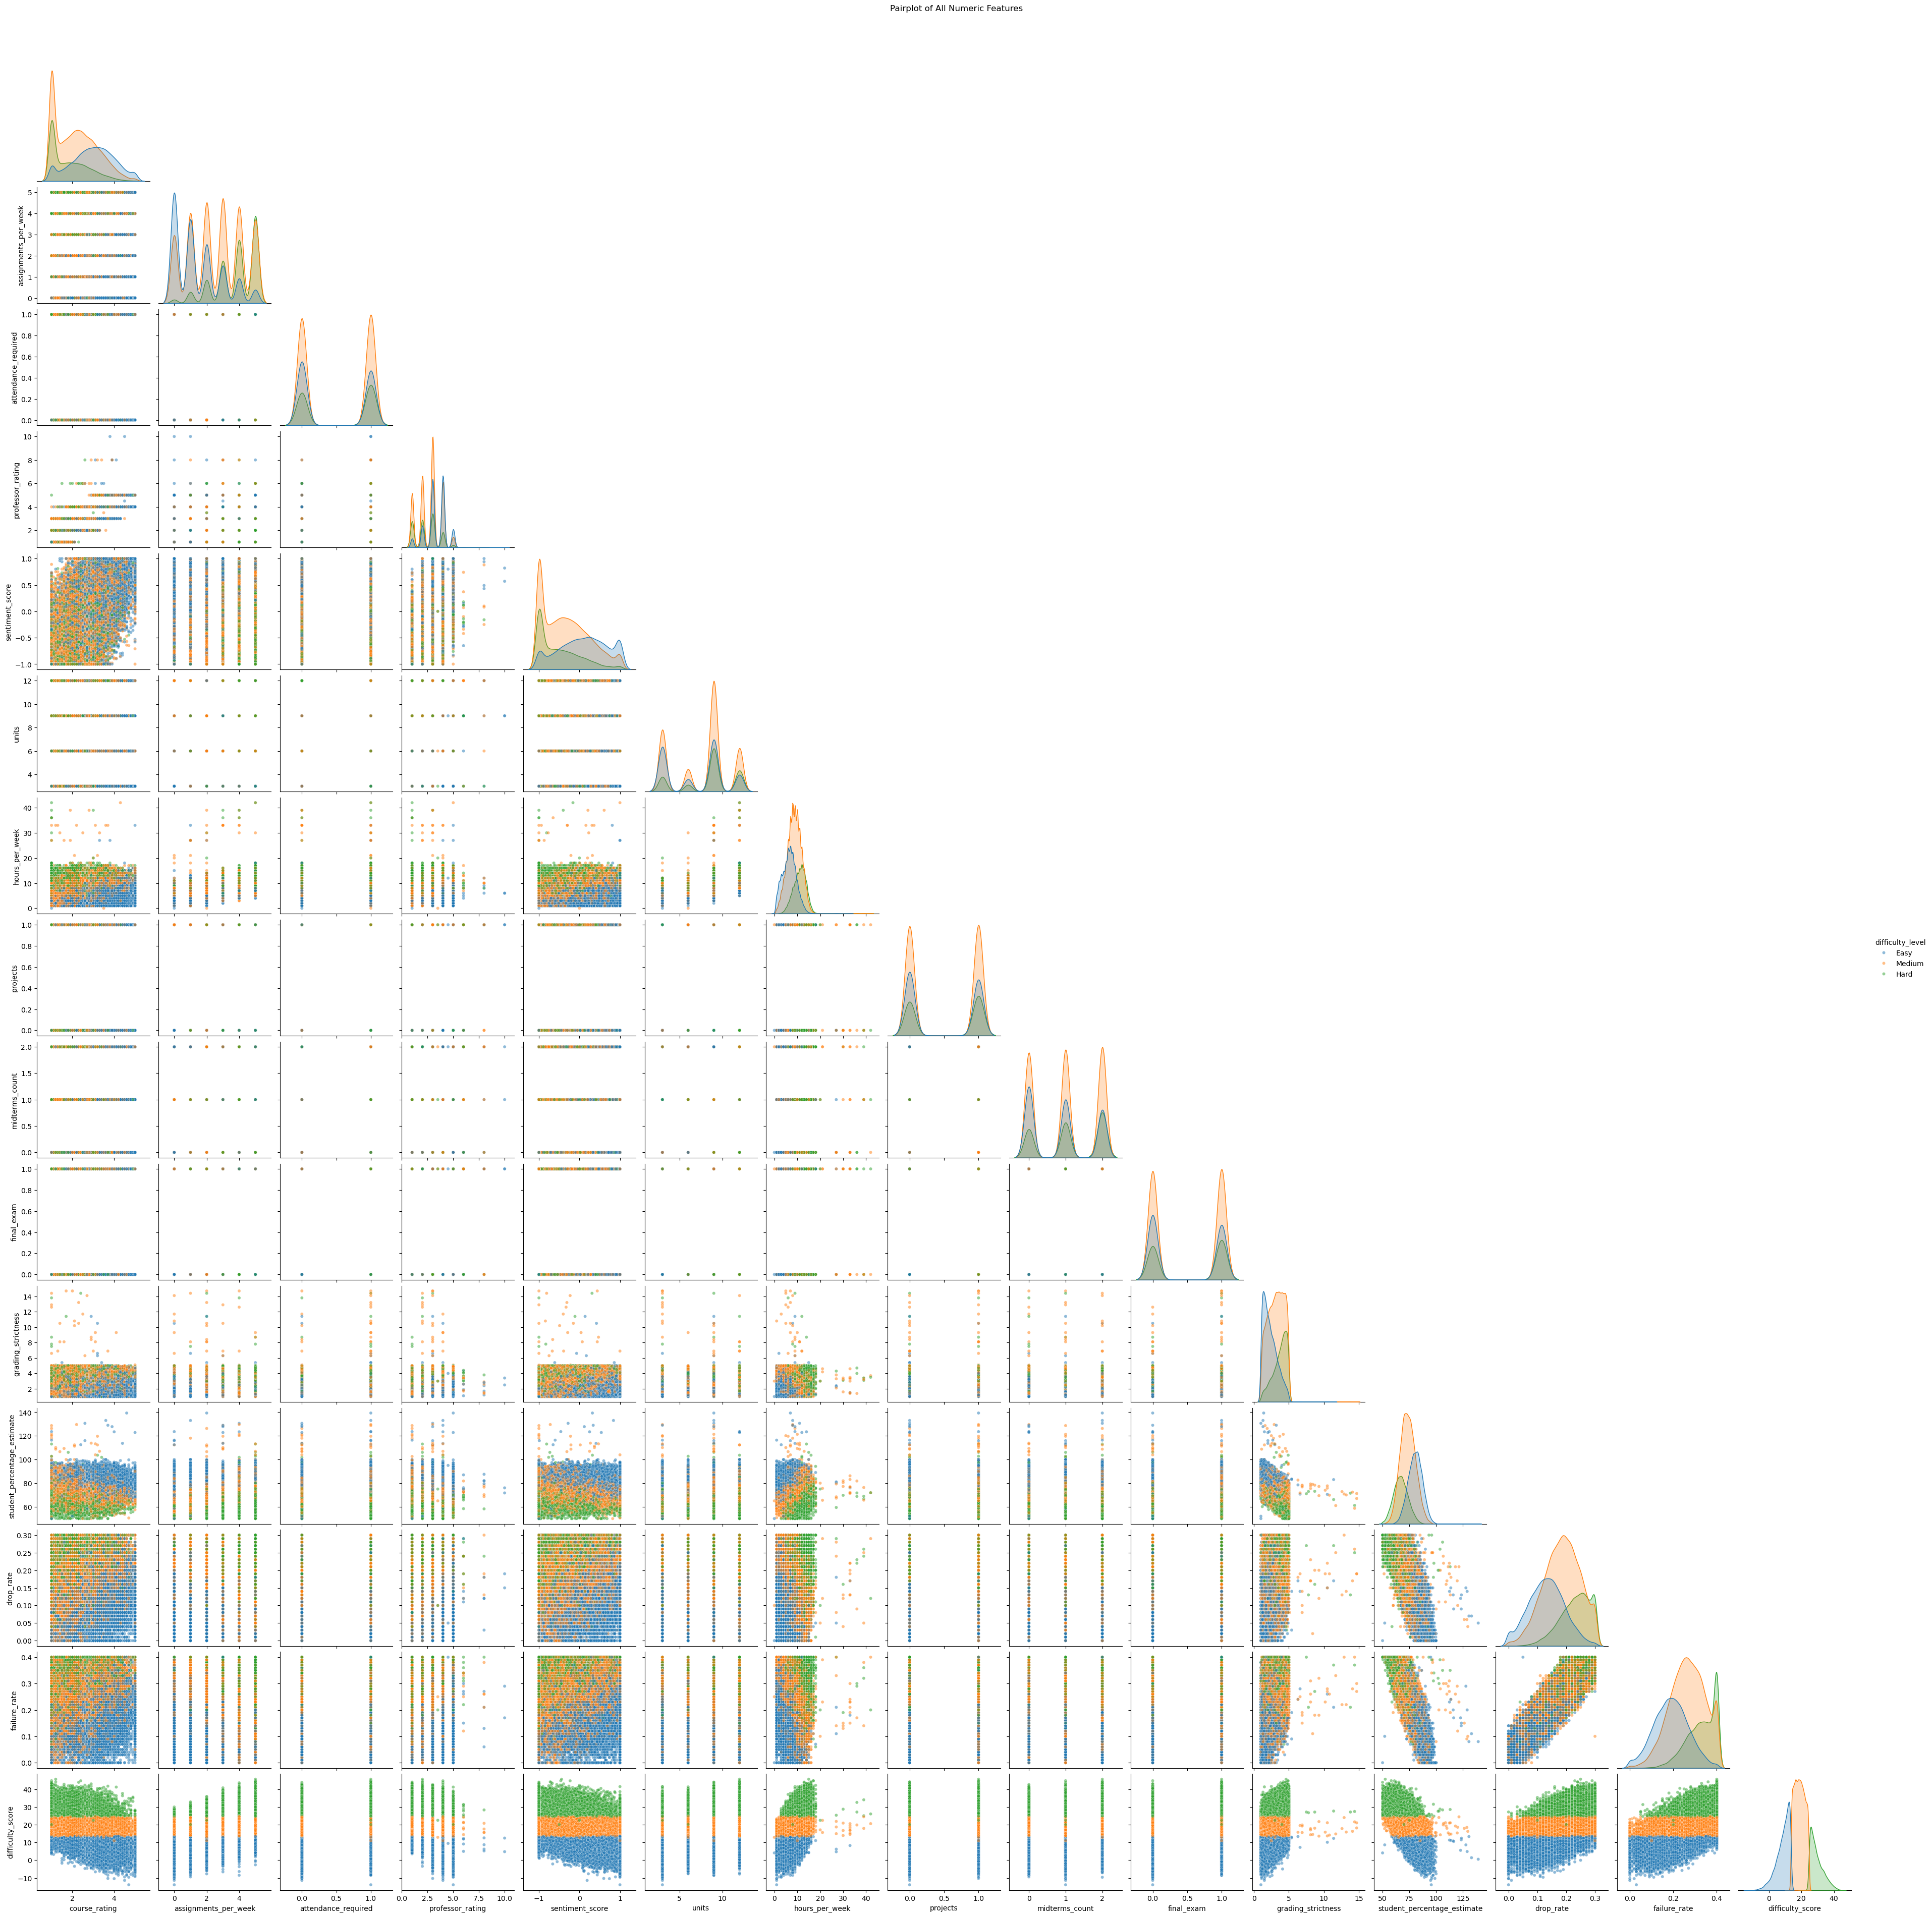

In [ ]:
# Create pairplot
sns.pairplot(numeric_df, hue='difficulty_level', corner=True, plot_kws={'alpha': 0.5, 's': 20})
plt.suptitle("Pairplot of All Numeric Features", y=1.02)
plt.show()


The pairplots above allow us to explore interactions between numerical features, separated by course difficulty levels (Easy, Medium, Hard):

- We observe **clear class separability** in combinations such as `course_rating vs. difficulty_score` and `grading_strictness vs. failure_rate`, supporting their predictive relevance.
- Some features like `hours_per_week`, `assignments_per_week`, and `sentiment_score` show **marginal trends**, with harder courses clustering toward more time commitment and negative sentiment.
- The bottom-most plot shows how `difficulty_score` distributes across difficulty classes.

These visualizations validate our feature engineering and suggest that the selected features are informative for predicting perceived course difficulty.

# D2.3 Data Wrangling

In [225]:
# We are loading the dirty dataset and displaying its basic structure, summary statistics, and data types for initial exploration.
df = pd.read_csv('dirty_course_difficulty_dataset.csv')
df.head()
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50010 entries, 0 to 50009
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   course_rating                49510 non-null  float64
 1   assignments_per_week         49510 non-null  float64
 2   attendance_required          49510 non-null  float64
 3   professor_rating             49510 non-null  float64
 4   sentiment_score              49510 non-null  float64
 5   subject_area                 49510 non-null  object 
 6   units                        49510 non-null  float64
 7   hours_per_week               49510 non-null  float64
 8   projects                     49510 non-null  float64
 9   midterms_count               49510 non-null  float64
 10  final_exam                   49510 non-null  float64
 11  grading_strictness           49510 non-null  float64
 12  student_percentage_estimate  49510 non-null  float64
 13  drop_rate       

course_rating  assignments_per_week  attendance_required  \
count   49510.000000          49510.000000         49510.000000   
mean        2.352268              2.491860             0.503918   
std         1.061965              1.704907             0.499990   
min         1.000000              0.000000             0.000000   
25%         1.400000              1.000000             0.000000   
50%         2.300000              2.000000             1.000000   
75%         3.100000              4.000000             1.000000   
max         5.000000              5.000000             1.000000   

       professor_rating  sentiment_score         units  hours_per_week  \
count      49510.000000     49510.000000  49510.000000    49510.000000   
mean           2.846385        -0.238269      7.637427        8.497172   
std            1.111749         0.608223      3.219126        3.358209   
min            1.000000        -1.000000      3.000000        0.000000   
25%            2.000000        -0.800000      3.000000        6.000000   
50%            3.000000        -0.300000      9.000000        8.000000   
75%            4.000000         0.210000      9.000000       11.000000   
max           10.000000         1.000000     12.000000       42.000000   

           projects  midterms_count    final_exam  grading_strictness  \
count  49510.000000    49510.000000  49510.000000        49510.000000   
mean       0.498990        1.001414      0.498768            3.006193   
std        0.500004        0.818077      0.500004            1.172944   
min        0.000000        0.000000      0.000000            1.000000   
25%        0.000000        0.000000      0.000000            2.000000   
50%        0.000000        1.000000      0.000000            3.000000   
75%        1.000000        2.000000      1.000000            4.000000   
max        1.000000        2.000000      1.000000           14.700000   

       student_percentage_estimate     drop_rate  failure_rate  \
count                 49510.000000  49510.000000  49510.000000   
mean                     74.305156      0.177803      0.254327   
std                       8.372437      0.069643      0.091470   
min                      50.000000      0.000000      0.000000   
25%                      68.400000      0.130000      0.190000   
50%                      74.200000      0.180000      0.260000   
75%                      80.200000      0.230000      0.320000   
max                     139.350000      0.300000      0.400000   

       difficulty_score  
count      50010.000000  
mean          17.850473  
std            8.158371  
min          -13.816594  
25%           12.351053  
50%           17.776792  
75%           23.278714  
max           46.320967

 We are adding duplicate rows ourselves to make more dirty (2%)

In [228]:
df = pd.concat([df, df.sample(frac=0.02)])  # 2% duplicate rows

In [230]:
# Check for duplicate rows
duplicate_mask = df.duplicated()

# Count duplicate rows
num_duplicates = duplicate_mask.sum()

# Print the result
print(f"Number of duplicate rows: {num_duplicates}")

Number of duplicate rows: 1000


In [232]:
# dropping any duplicate rows
df = df.drop_duplicates()

showing NO DUPLICATE ROWS

In [235]:
# Check for duplicate rows
duplicate_mask = df.duplicated()

# Count duplicate rows
num_duplicates = duplicate_mask.sum()

# Print the result
print(f"Number of duplicate rows: {num_duplicates}")

Number of duplicate rows: 0


---------------------

We are imputing missing values by filling numeric columns with their mean and categorical columns with their most frequent value (mode) to restore dataset completeness for analysis.

In [239]:
from scipy.stats import shapiro

# Step 1: Drop rows with more than one missing value
df = df[df.isnull().sum(axis=1) <= 1].reset_index(drop=True)

# Step 2: Identify numeric and categorical columns
num_cols = df.select_dtypes(include='number').columns.tolist()
cat_cols = df.select_dtypes(include='object').columns.tolist()

# Step 3: Identify which numeric columns are normally distributed
is_normal_dict = {}
for col in num_cols:
    data = df[col].dropna()
    p = shapiro(data.sample(min(5000, len(data))))[1]
    is_normal_dict[col] = p > 0.05  # True if normally distributed

# Step 4: Group-based imputation
for col in num_cols:
    if is_normal_dict[col]:  # Normal → use mean
        df[col] = df.groupby('difficulty_level')[col].transform(lambda x: x.fillna(x.mean()))
    else:  # Skewed → use median
        df[col] = df.groupby('difficulty_level')[col].transform(lambda x: x.fillna(x.median()))

for col in cat_cols:
    df[col] = df.groupby('difficulty_level')[col].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else 'Unknown'))


We are testing the normality of each numeric feature using the Shapiro-Wilk test, sampling up to 5,000 values per column, and classifying each as normally distributed or not based on a significance level of 0.05.

In [242]:
from scipy.stats import shapiro

# Get numeric columns (excluding any NaNs)
numeric_cols = df.select_dtypes(include='number').columns.tolist()

# Create the normality dictionary using Shapiro-Wilk test
is_normal_dict = {}
alpha = 0.05  # significance level

for col in numeric_cols:
    # Drop NaNs for the test
    data = df[col].dropna()

    # Shapiro-Wilk test: returns statistic and p-value
    stat, p_value = shapiro(data.sample(min(len(data), 5000)))  # use sample to speed up for large sets

    is_normal = p_value > alpha  # if p > 0.05, we consider the distribution normal
    is_normal_dict[col] = is_normal
    print(f"{col}: {'Normal' if is_normal else 'Not normal'} (p = {p_value:.4f})")

course_rating: Not normal (p = 0.0000)
assignments_per_week: Not normal (p = 0.0000)
attendance_required: Not normal (p = 0.0000)
professor_rating: Not normal (p = 0.0000)
sentiment_score: Not normal (p = 0.0000)
units: Not normal (p = 0.0000)
hours_per_week: Not normal (p = 0.0000)
projects: Not normal (p = 0.0000)
midterms_count: Not normal (p = 0.0000)
final_exam: Not normal (p = 0.0000)
grading_strictness: Not normal (p = 0.0000)
student_percentage_estimate: Not normal (p = 0.0000)
drop_rate: Not normal (p = 0.0000)
failure_rate: Not normal (p = 0.0000)
difficulty_score: Normal (p = 0.1268)


--------------------------------

We are now defining a function to detect outliers in each numeric column by applying the Z-score method for normally distributed features and the IQR method for non-normal ones, then combining the results into a single mask to flag all outlier rows.

In [246]:
def detect_outliers(df, is_normal_dict):
    outlier_mask = pd.Series(False, index=df.index)

    for col in numeric_cols:
        data = df[col]

        if is_normal_dict[col]:
            # Z-score method for normal distribution
            mean_val = data.mean()
            std_val = data.std()
            z_scores = (data - mean_val) / std_val
            col_mask = abs(z_scores) > 2.5
        else:
            # IQR method for non-normal distribution
            Q1 = data.quantile(0.25)
            Q3 = data.quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            col_mask = (data < lower_bound) | (data > upper_bound)

        print(f"Column '{col}': {col_mask.sum()} outliers detected.")
        outlier_mask |= col_mask  # Combine this column’s mask with the overall

    return outlier_mask


We are applying the outlier detection function to flag and count outlier rows, then removing them to create a cleaned version of the dataset for further analysis.

In [249]:
# Apply the outlier detection
mask = detect_outliers(df, is_normal_dict)
print(f"\nTotal rows flagged as outliers: {mask.sum()}")

# Remove outliers
df_clean = df[~mask].reset_index(drop=True)
print(f"Cleaned dataset shape: {df_clean.shape}")

Column 'course_rating': 0 outliers detected.
Column 'assignments_per_week': 0 outliers detected.
Column 'attendance_required': 0 outliers detected.
Column 'professor_rating': 13 outliers detected.
Column 'sentiment_score': 0 outliers detected.
Column 'units': 0 outliers detected.
Column 'hours_per_week': 37 outliers detected.
Column 'projects': 0 outliers detected.
Column 'midterms_count': 0 outliers detected.
Column 'final_exam': 0 outliers detected.
Column 'grading_strictness': 30 outliers detected.
Column 'student_percentage_estimate': 125 outliers detected.
Column 'drop_rate': 0 outliers detected.
Column 'failure_rate': 0 outliers detected.
Column 'difficulty_score': 587 outliers detected.

Total rows flagged as outliers: 775
Cleaned dataset shape: (48718, 17)


# D2.4 Feature Engineering

## 1. Feature Importance: Correlation with Target

We are preparing the dataset for modeling by mapping difficulty levels to numeric values and applying one-hot encoding to convert the categorical subject_area feature into numerical format.

In [254]:
# Map labels to numeric for correlation
df_fe = df.copy()
df_fe['difficulty_level_num'] = df_fe['difficulty_level'].map({'Easy': 0, 'Medium': 1, 'Hard': 2})
df_fe = df_fe.drop('difficulty_level', axis=1)

# One-Hot Encoding to cast subject area variable to a numerical value
df_fe = pd.get_dummies(df_fe, columns=['subject_area'])

We are calculating the absolute correlation of each feature with the target variable `difficulty_level_num`, sorting them to identify the most influential predictors, and visualizing the results with a barplot for easier interpretation.

Correlation with difficulty_level:
difficulty_score               0.897999
student_percentage_estimate    0.561276
failure_rate                   0.531088
drop_rate                      0.498824
assignments_per_week           0.479462
hours_per_week                 0.469961
grading_strictness             0.417462
subject_area_STEM              0.402503
course_rating                  0.387687
sentiment_score                0.359988
professor_rating               0.308558
subject_area_Humanities        0.245599
units                          0.163256
subject_area_Social Science    0.157399
midterms_count                 0.121671
attendance_required            0.073112
final_exam                     0.063034
projects                       0.055566
Name: difficulty_level_num, dtype: float64


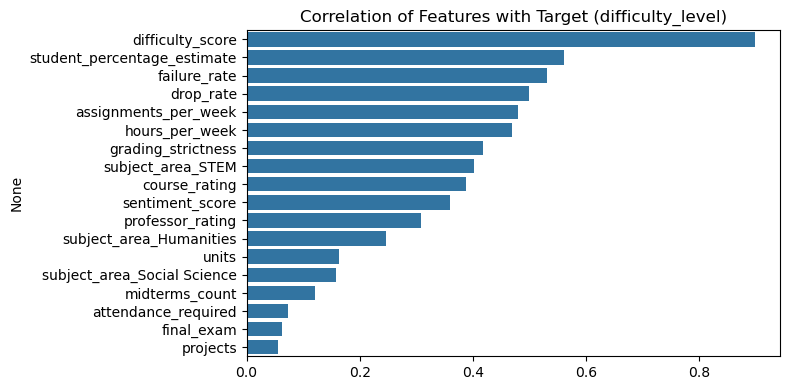

course_rating  assignments_per_week  attendance_required  \
0                4.2                   0.0                  0.0   
1                2.2                   1.0                  1.0   
2                2.6                   3.0                  1.0   
3                1.5                   2.0                  0.0   
4                1.9                   5.0                  1.0   
...              ...                   ...                  ...   
49488            2.0                   1.0                  0.0   
49489            3.0                   0.0                  1.0   
49490            5.0                   3.0                  1.0   
49491            1.0                   1.0                  1.0   
49492            3.0                   2.0                  1.0   

       professor_rating  sentiment_score  units  hours_per_week  projects  \
0                   4.0             1.00    6.0             4.0       0.0   
1                   3.0            -0.71    9.0             6.0       1.0   
2                   3.0            -0.26    9.0             7.0       0.0   
3                   2.0            -0.89    9.0             9.0       0.0   
4                   2.0             0.43   12.0            14.0       1.0   
...                 ...              ...    ...             ...       ...   
49488               3.0            -0.30    3.0             5.0       0.0   
49489               4.0             0.20    6.0            20.0       1.0   
49490               5.0            -1.00   12.0            15.0       1.0   
49491               5.0            -0.50    6.0             8.0       0.0   
49492               3.5             0.00    3.0            20.0       1.0   

       midterms_count  final_exam  grading_strictness  \
0                 1.0         1.0                 1.7   
1                 1.0         0.0                 4.2   
2                 0.0         0.0                 2.6   
3                 2.0         0.0                 1.2   
4                 2.0         1.0                 1.5   
...               ...         ...                 ...   
49488             0.0         1.0                 5.0   
49489             1.0         1.0                 3.0   
49490             2.0         1.0                 3.5   
49491             1.0         1.0                 4.0   
49492             1.0         1.0                 3.0   

       student_percentage_estimate  drop_rate  failure_rate  difficulty_score  \
0                             80.6       0.14          0.12         -0.239720   
1                             66.5       0.20          0.29         16.345990   
2                             80.7       0.14          0.21         12.477249   
3                             81.0       0.07          0.14         17.988776   
4                             88.7       0.06          0.27         18.274062   
...                            ...        ...           ...               ...   
49488                         60.0       0.10          0.30         14.113071   
49489                         80.0       0.05          0.10         17.078283   
49490                         90.0       0.05          0.05         17.821790   
49491                         70.0       0.20          0.20         20.074865   
49492                         75.0       0.10          0.20         22.479648   

       difficulty_level_num  subject_area_Humanities  subject_area_STEM  \
0                         0                    False              False   
1                         1                    False              False   
2                         0                     True              False   
3                         1                    False               True   
4                         1                    False              False   
...                     ...                      ...                ...   
49488                     1                     True              False   
49489              

In [257]:
# Correlation with target
corrs = df_fe.corr(numeric_only=True)['difficulty_level_num'].drop('difficulty_level_num')
corrs = corrs.abs().sort_values(ascending=False)
print("Correlation with difficulty_level:")
print(corrs)

# Plot top correlations
plt.figure(figsize=(8, 4))
sns.barplot(x=corrs.values, y=corrs.index)
plt.title("Correlation of Features with Target (difficulty_level)")
plt.tight_layout()
plt.show()
df_fe

## 2. Prune Redundant Features

We are visualizing the full correlation matrix of the feature-engineered dataset to examine relationships between all numeric variables, including the encoded target and one-hot encoded subject areas.










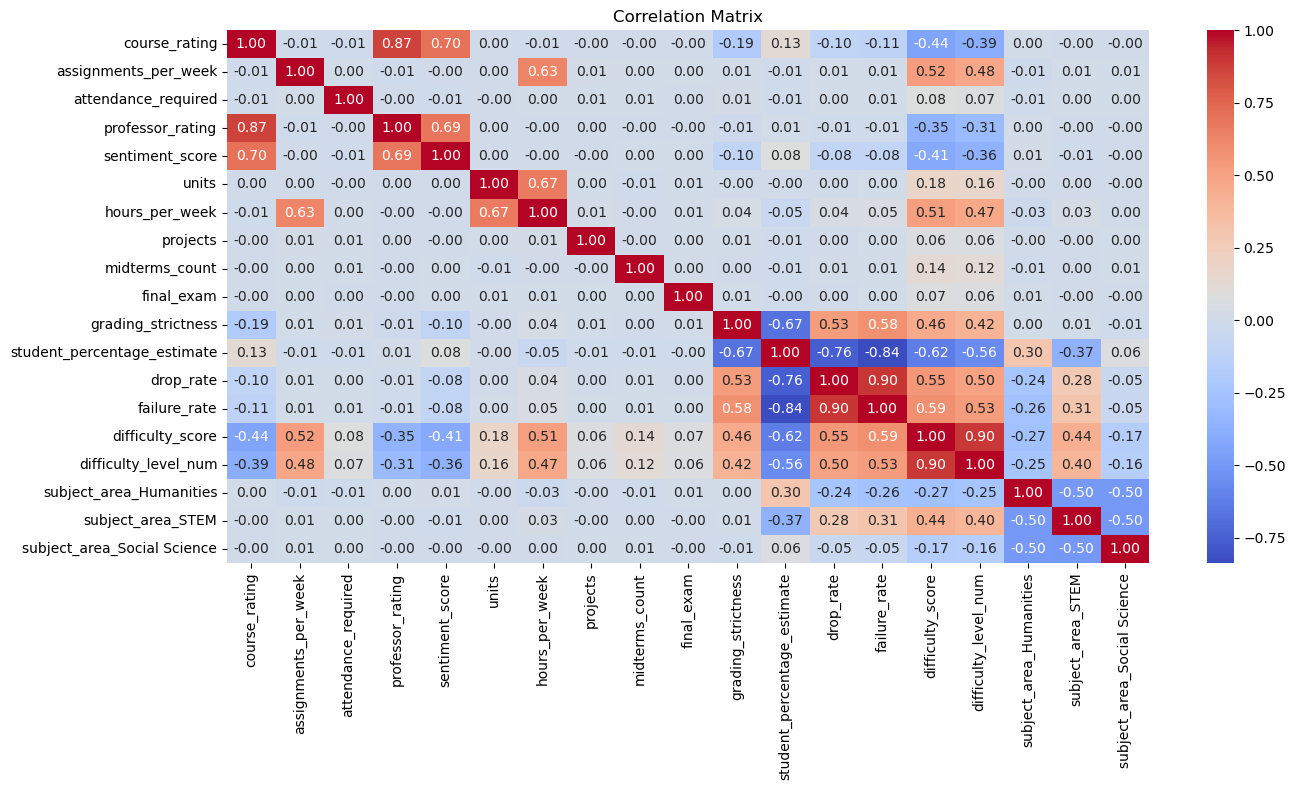

In [261]:
plt.figure(figsize=(14, 8))
sns.heatmap(df_fe.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

----------------

We are removing highly correlated and redundant features to reduce multicollinearity and simplify the dataset, keeping only the most informative predictors for modeling.

In [265]:
# Drop if highly correlated (>0.8) or duplicates
df_fe = df_fe.drop(columns=[
    'drop_rate',          # due to 0.90 corr with failure_rate
    'student_percentage_estimate', # due to -0.81 corr with failiure_rate
    'professor_rating',    # due to 0.87 corr with course_rating
    'difficulty_score'    # due to 0.89 corr with difficulty_level_num

])

-------------

We are re-plotting the correlation matrix after dropping highly correlated features to confirm reduced multicollinearity and ensure the remaining variables are more independent for modeling.

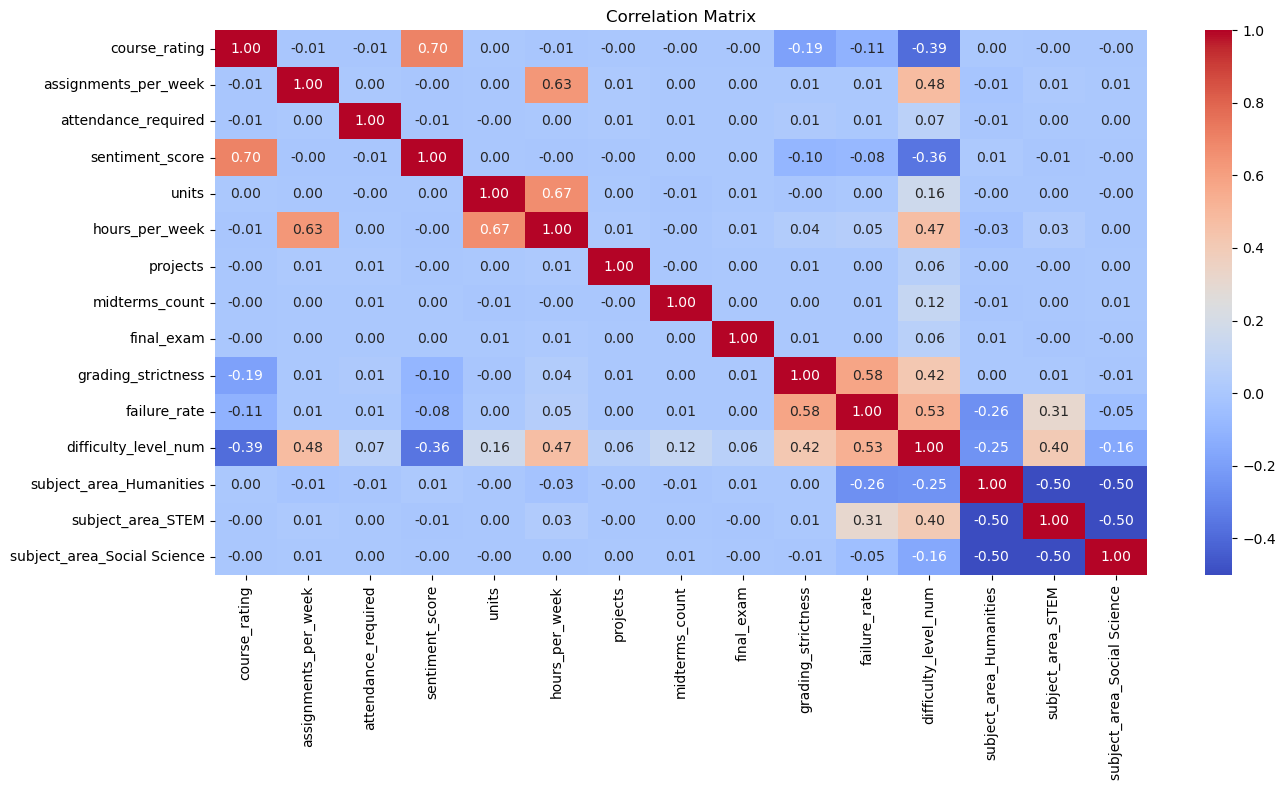

In [269]:
plt.figure(figsize=(14, 8))
sns.heatmap(df_fe.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

##  3. Feature Creation

We are engineering a new feature: effort_score, which quantifies the actual workload by combining hours, assignments, and units into a single metric.


Engineering New Features: `effort_score`

We introduce an engineered feature to better capture the real-world course difficulty from multiple angles:

1. **`effort_score`**  
   This feature estimates the objective workload of a course based on:
   - Time commitment (`hours_per_week`)
   - Structural demands (`assignments_per_week`, `projects`, `midterms_count`, `final_exam`)
   - Credit weight (`units`)

   Each component is weighted to reflect its influence (e.g., midterms might be more demanding than a project). After summing these components, the raw `effort_score` is standardized using `StandardScaler` to follow a normal distribution (~N(0,1)), then clipped between -2 and +2 for interpretability.

In [273]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Select workload-related features
effort_components = df_fe[[
    'units',
    'hours_per_week',
    'assignments_per_week',
    'projects',
    'midterms_count',
    'final_exam'
]].copy()

# Optional: assign weights if needed, otherwise equal weight is fine
# Example weights for balanced contribution
weights = {
    'units': 0.4,
    'hours_per_week': 0.3,
    'assignments_per_week': 0.2,
    'projects': 0.5,
    'midterms_count': 0.6,
    'final_exam': 0.4
}

# Apply weights
for col in effort_components.columns:
    effort_components[col] *= weights[col]

# Combine all into a single raw effort score
df_fe['effort_score_raw'] = effort_components.sum(axis=1)

# Standardize to roughly follow a Gaussian distribution (mean ~0, std ~1)
scaler = StandardScaler()
df_fe['effort_score'] = scaler.fit_transform(df_fe[['effort_score_raw']])

# Rescale to range ~[-2, +2] for Gaussian std range
df_fe['effort_score'] = np.clip(df_fe['effort_score'], -2, 2)

# Drop raw version
df_fe.drop(columns=['effort_score_raw'], inplace=True)

is_normal_dict['effort_score'] = True

## 4. Feature Scaling

We are scaling all numeric features (excluding the target variable) using robut scaler to ensure they are on the same scale, which is essential for many machine learning algorithms to perform effectively.

In [148]:
from sklearn.preprocessing import StandardScaler, RobustScaler

# # Step 1: Detect numeric columns (excluding label)
# numeric_cols = df_fe.select_dtypes(include='number').columns.tolist()
# numeric_cols.remove('difficulty_level_num')

# scaler_non_norm = RobustScaler()
# scaler_norm = StandardScaler()
# # Step 2: Scale based on normality result
# for col in numeric_cols:
#     if is_normal_dict[col]:
#         df_fe[[col]] = scaler_norm.fit_transform(df_fe[[col]])
#     else:
#         df_fe[[col]] = scaler_non_norm.fit_transform(df_fe[[col]])
    


# print("All numeric features scaled (excluding target).")




All numeric features scaled (excluding target).


In [277]:
import joblib

# 1) Grab all numeric columns and drop the target
numeric_cols = df_fe.select_dtypes(include='number').columns.tolist()
numeric_cols.remove('difficulty_level_num')

# 2) Split them based on your normality test
non_norm_feats = [c for c in numeric_cols if not is_normal_dict[c]]
norm_feats     = [c for c in numeric_cols if is_normal_dict[c]]

# Now 'non_norm_feats' will be exactly those with False in normality_dict
# and 'norm_feats' those with True (e.g. 'difficulty_score' and 'effort_score').

# Fit & dump a single RobustScaler on all skewed features
scaler_non_norm = RobustScaler().fit(df_fe[non_norm_feats])
df_fe[non_norm_feats] = scaler_non_norm.transform(df_fe[non_norm_feats])
joblib.dump(scaler_non_norm, 'scaler_non_normal.pkl')

# Fit & dump a single StandardScaler on all normal features
scaler_norm = StandardScaler().fit(df_fe[norm_feats])
df_fe[norm_feats] = scaler_norm.transform(df_fe[norm_feats])
joblib.dump(scaler_norm, 'scaler_norm_all.pkl')

['scaler_norm_all.pkl']

In [150]:
print(scaler)

StandardScaler()


In [279]:
print(is_normal_dict)

{'course_rating': False, 'assignments_per_week': False, 'attendance_required': False, 'professor_rating': False, 'sentiment_score': False, 'units': False, 'hours_per_week': False, 'projects': False, 'midterms_count': False, 'final_exam': False, 'grading_strictness': False, 'student_percentage_estimate': False, 'drop_rate': False, 'failure_rate': False, 'difficulty_score': True, 'effort_score': True}


In [154]:
# import joblib
# joblib.dump(scaler_non_norm, 'scaler_non_norm.pkl')
# joblib.dump(scaler_norm, 'scaler_norm.pkl')


['scaler_norm.pkl']

# Targeted Final Exploratory Data Analysis

We are reviewing the final dataset's structure, types, and statistics to confirm it's clean and ready for modeling.

In [ ]:
df_fe.head()
df_fe.info()
df_fe.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49493 entries, 0 to 49492
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   course_rating                49493 non-null  float64
 1   assignments_per_week         49493 non-null  float64
 2   attendance_required          49493 non-null  float64
 3   sentiment_score              49493 non-null  float64
 4   units                        49493 non-null  float64
 5   hours_per_week               49493 non-null  float64
 6   projects                     49493 non-null  float64
 7   midterms_count               49493 non-null  float64
 8   final_exam                   49493 non-null  float64
 9   grading_strictness           49493 non-null  float64
 10  failure_rate                 49493 non-null  float64
 11  difficulty_level_num         49493 non-null  int64  
 12  subject_area_Humanities      49493 non-null  bool   
 13  subject_area_STE

course_rating  assignments_per_week  attendance_required  \
count   49493.000000          49493.000000         49493.000000   
mean        0.030123              0.164131            -0.493888   
std         0.622621              0.567016             0.499968   
min        -0.764706             -0.666667            -1.000000   
25%        -0.529412             -0.333333            -1.000000   
50%         0.000000              0.000000             0.000000   
75%         0.470588              0.666667             0.000000   
max         1.588235              1.000000             0.000000   

       sentiment_score         units  hours_per_week      projects  \
count     49493.000000  49493.000000    49493.000000  49493.000000   
mean          0.060433     -0.225355       -0.100253     -0.499323   
std           0.600300      0.534639        0.669280      0.500005   
min          -0.693069     -1.000000       -1.800000     -1.000000   
25%          -0.495050     -1.000000       -0.600000     -1.000000   
50%           0.000000      0.000000        0.000000      0.000000   
75%           0.504950      0.000000        0.400000      0.000000   
max           1.287129      0.500000        6.600000      0.000000   

       midterms_count    final_exam  grading_strictness  failure_rate  \
count    49493.000000  49493.000000        49493.000000  49493.000000   
mean         0.000707     -0.499646            0.002666     -0.043818   
std          0.407203      0.500005            0.584731      0.701755   
min         -0.500000     -1.000000           -1.000000     -2.000000   
25%         -0.500000     -1.000000           -0.500000     -0.538462   
50%          0.000000      0.000000            0.000000      0.000000   
75%          0.500000      0.000000            0.500000      0.461538   
max          0.500000      0.000000            5.850000      1.076923   

       difficulty_level_num  effort_score  
count          49493.000000  4.949300e+04  
mean               0.899885 -9.008659e-18  
std                0.700229  1.000010e+00  
min                0.000000 -2.059751e+00  
25%                0.000000 -7.139226e-01  
50%                1.000000  1.570195e-02  
75%                1.000000  7.221638e-01  
max                2.000000  2.057034e+00

We are checking how strongly the new feature effort_score correlate with the target variable to evaluate their relevance for prediction.

In [ ]:
# 1. Check correlation with target
new_features = ['effort_score']
for feature in new_features:
    corr = df_fe[feature].corr(df_fe['difficulty_level_num'])
    print(f"Correlation of {feature} with difficulty_level_num: {corr:.3f}")


Correlation of effort_score with difficulty_level_num: 0.404


We are plotting the final correlation matrix to visualize relationships among all numeric features, including newly engineered ones, and assess their alignment with the target variable.

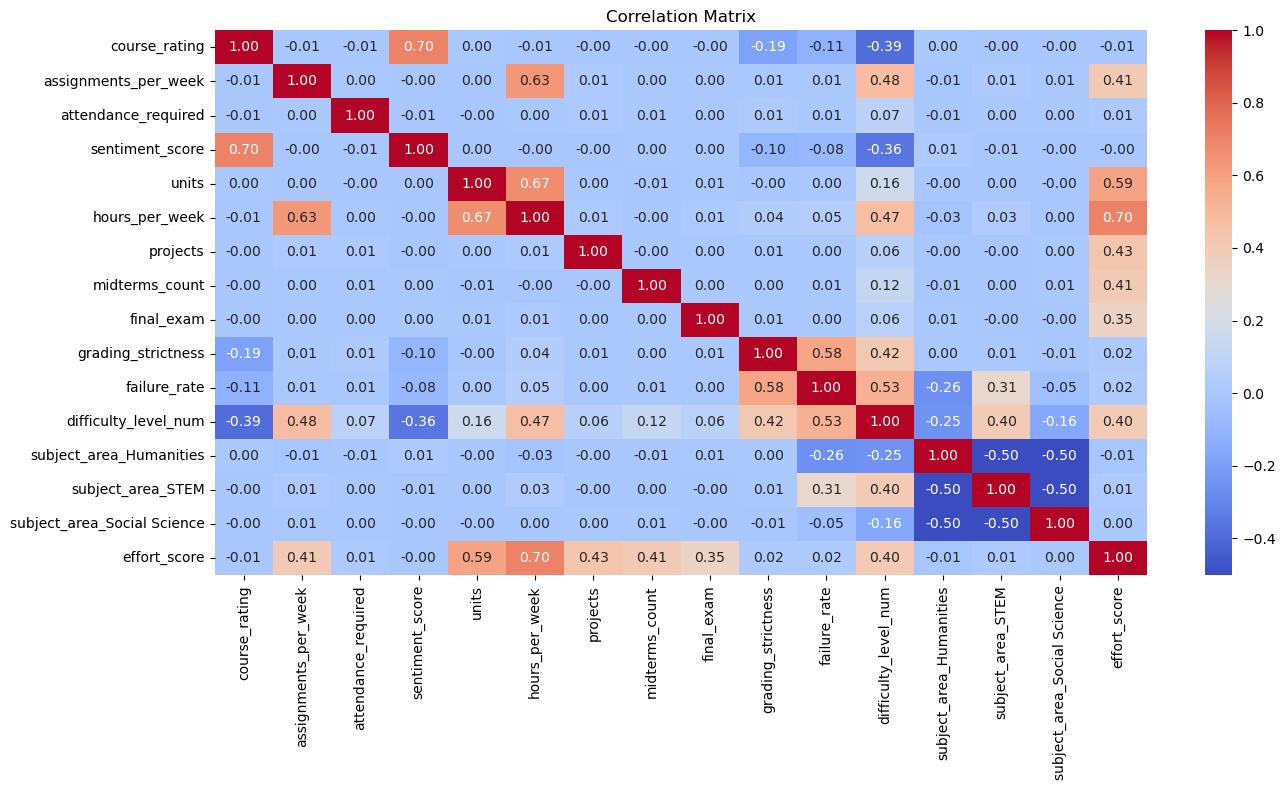

In [ ]:
plt.figure(figsize=(14, 8))
sns.heatmap(df_fe.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()


------------

We are printing a sorted list of feature correlations with the target `difficulty_level_num` to identify which variables are most positively or negatively associated with course difficulty.

In [ ]:
corrs = df_fe.corr()['difficulty_level_num'].sort_values(ascending=False)
print(corrs)

difficulty_level_num           1.000000
failure_rate                   0.531088
assignments_per_week           0.479462
hours_per_week                 0.469961
grading_strictness             0.417462
effort_score                   0.404239
subject_area_STEM              0.402503
units                          0.163256
midterms_count                 0.121671
attendance_required            0.073112
final_exam                     0.063034
projects                       0.055566
subject_area_Social Science   -0.157399
subject_area_Humanities       -0.245599
sentiment_score               -0.359988
course_rating                 -0.387687
Name: difficulty_level_num, dtype: float64


------------

We are using boxplots to visualize how each numeric feature varies across difficulty levels, helping us spot trends, differences, and potential predictors for course difficulty classification.

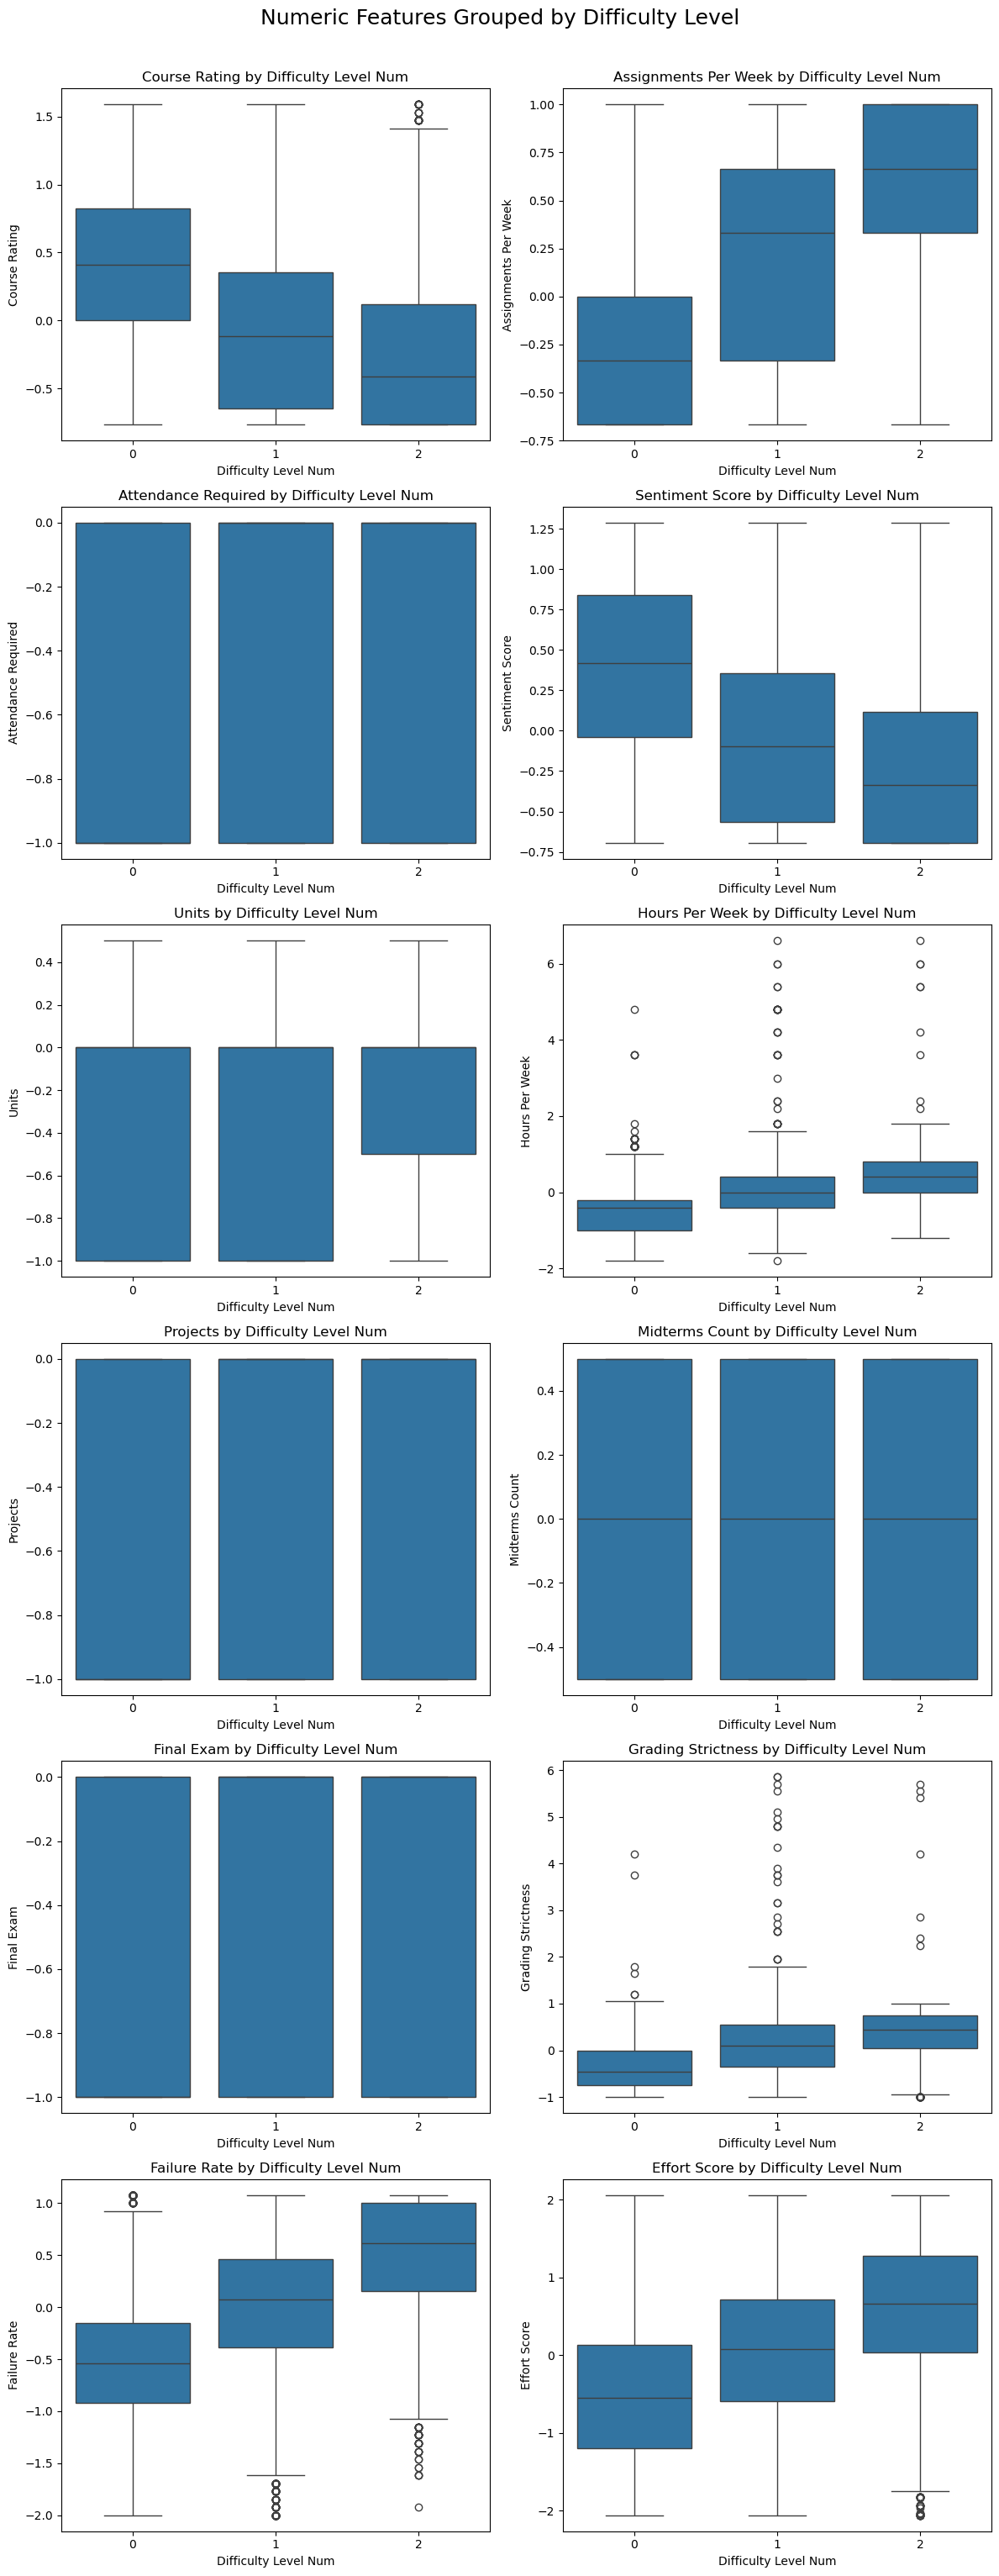

In [ ]:



plot_boxplot_grid(
    df=df_fe,
    features=[col for col in df_fe.select_dtypes(include='number').columns if col != 'difficulty_level_num'],
    group_by='difficulty_level_num',
    title="Numeric Features Grouped by Difficulty Level"
)



These boxplots provide insight into how each numeric feature behaves across `Easy (0)`, `Medium (1)`, and `Hard (2)` courses after full preprocessing.

#### Key Observations:
- **Course Rating**: Median rating decreases as difficulty increases. Hard courses are rated the lowest, indicating perceived difficulty negatively impacts student satisfaction.
- **Assignments per Week**: Increases with difficulty. Hard courses tend to assign more weekly work than Easy or Medium ones.
- **Attendance Required**: Constant across all difficulty levels (binary). This feature likely has low predictive value after scaling.
- **Sentiment Score**: Clearly drops from Easy to Hard. Students express more negative sentiment in harder classes, aligning with expectations.
- **Hours per Week**: Increases with difficulty. Hard courses demand significantly more time, as seen by the longer upper whiskers.
- **Projects, Midterms, Final Exam**: These binary variables appear mostly flat — suggesting they're evenly distributed across difficulty levels.
- **Grading Strictness**: Shows a rising trend; hard courses have both a higher median and more outliers for strict grading.
- **Failure Rate**: Strong upward trend. Hard courses show much higher failure rates, validating our engineered labels.
- **Effort Score**: Also increases with difficulty, reinforcing the notion that our engineered metric successfully captures course workload.

These final plots confirm that our data preprocessing preserved interpretable structure and captured useful signals for prediction.

-----------

We are plotting the distribution of each numeric feature to examine their shape, spread, and skewness, which helps in understanding data behavior and detecting anomalies before modeling.

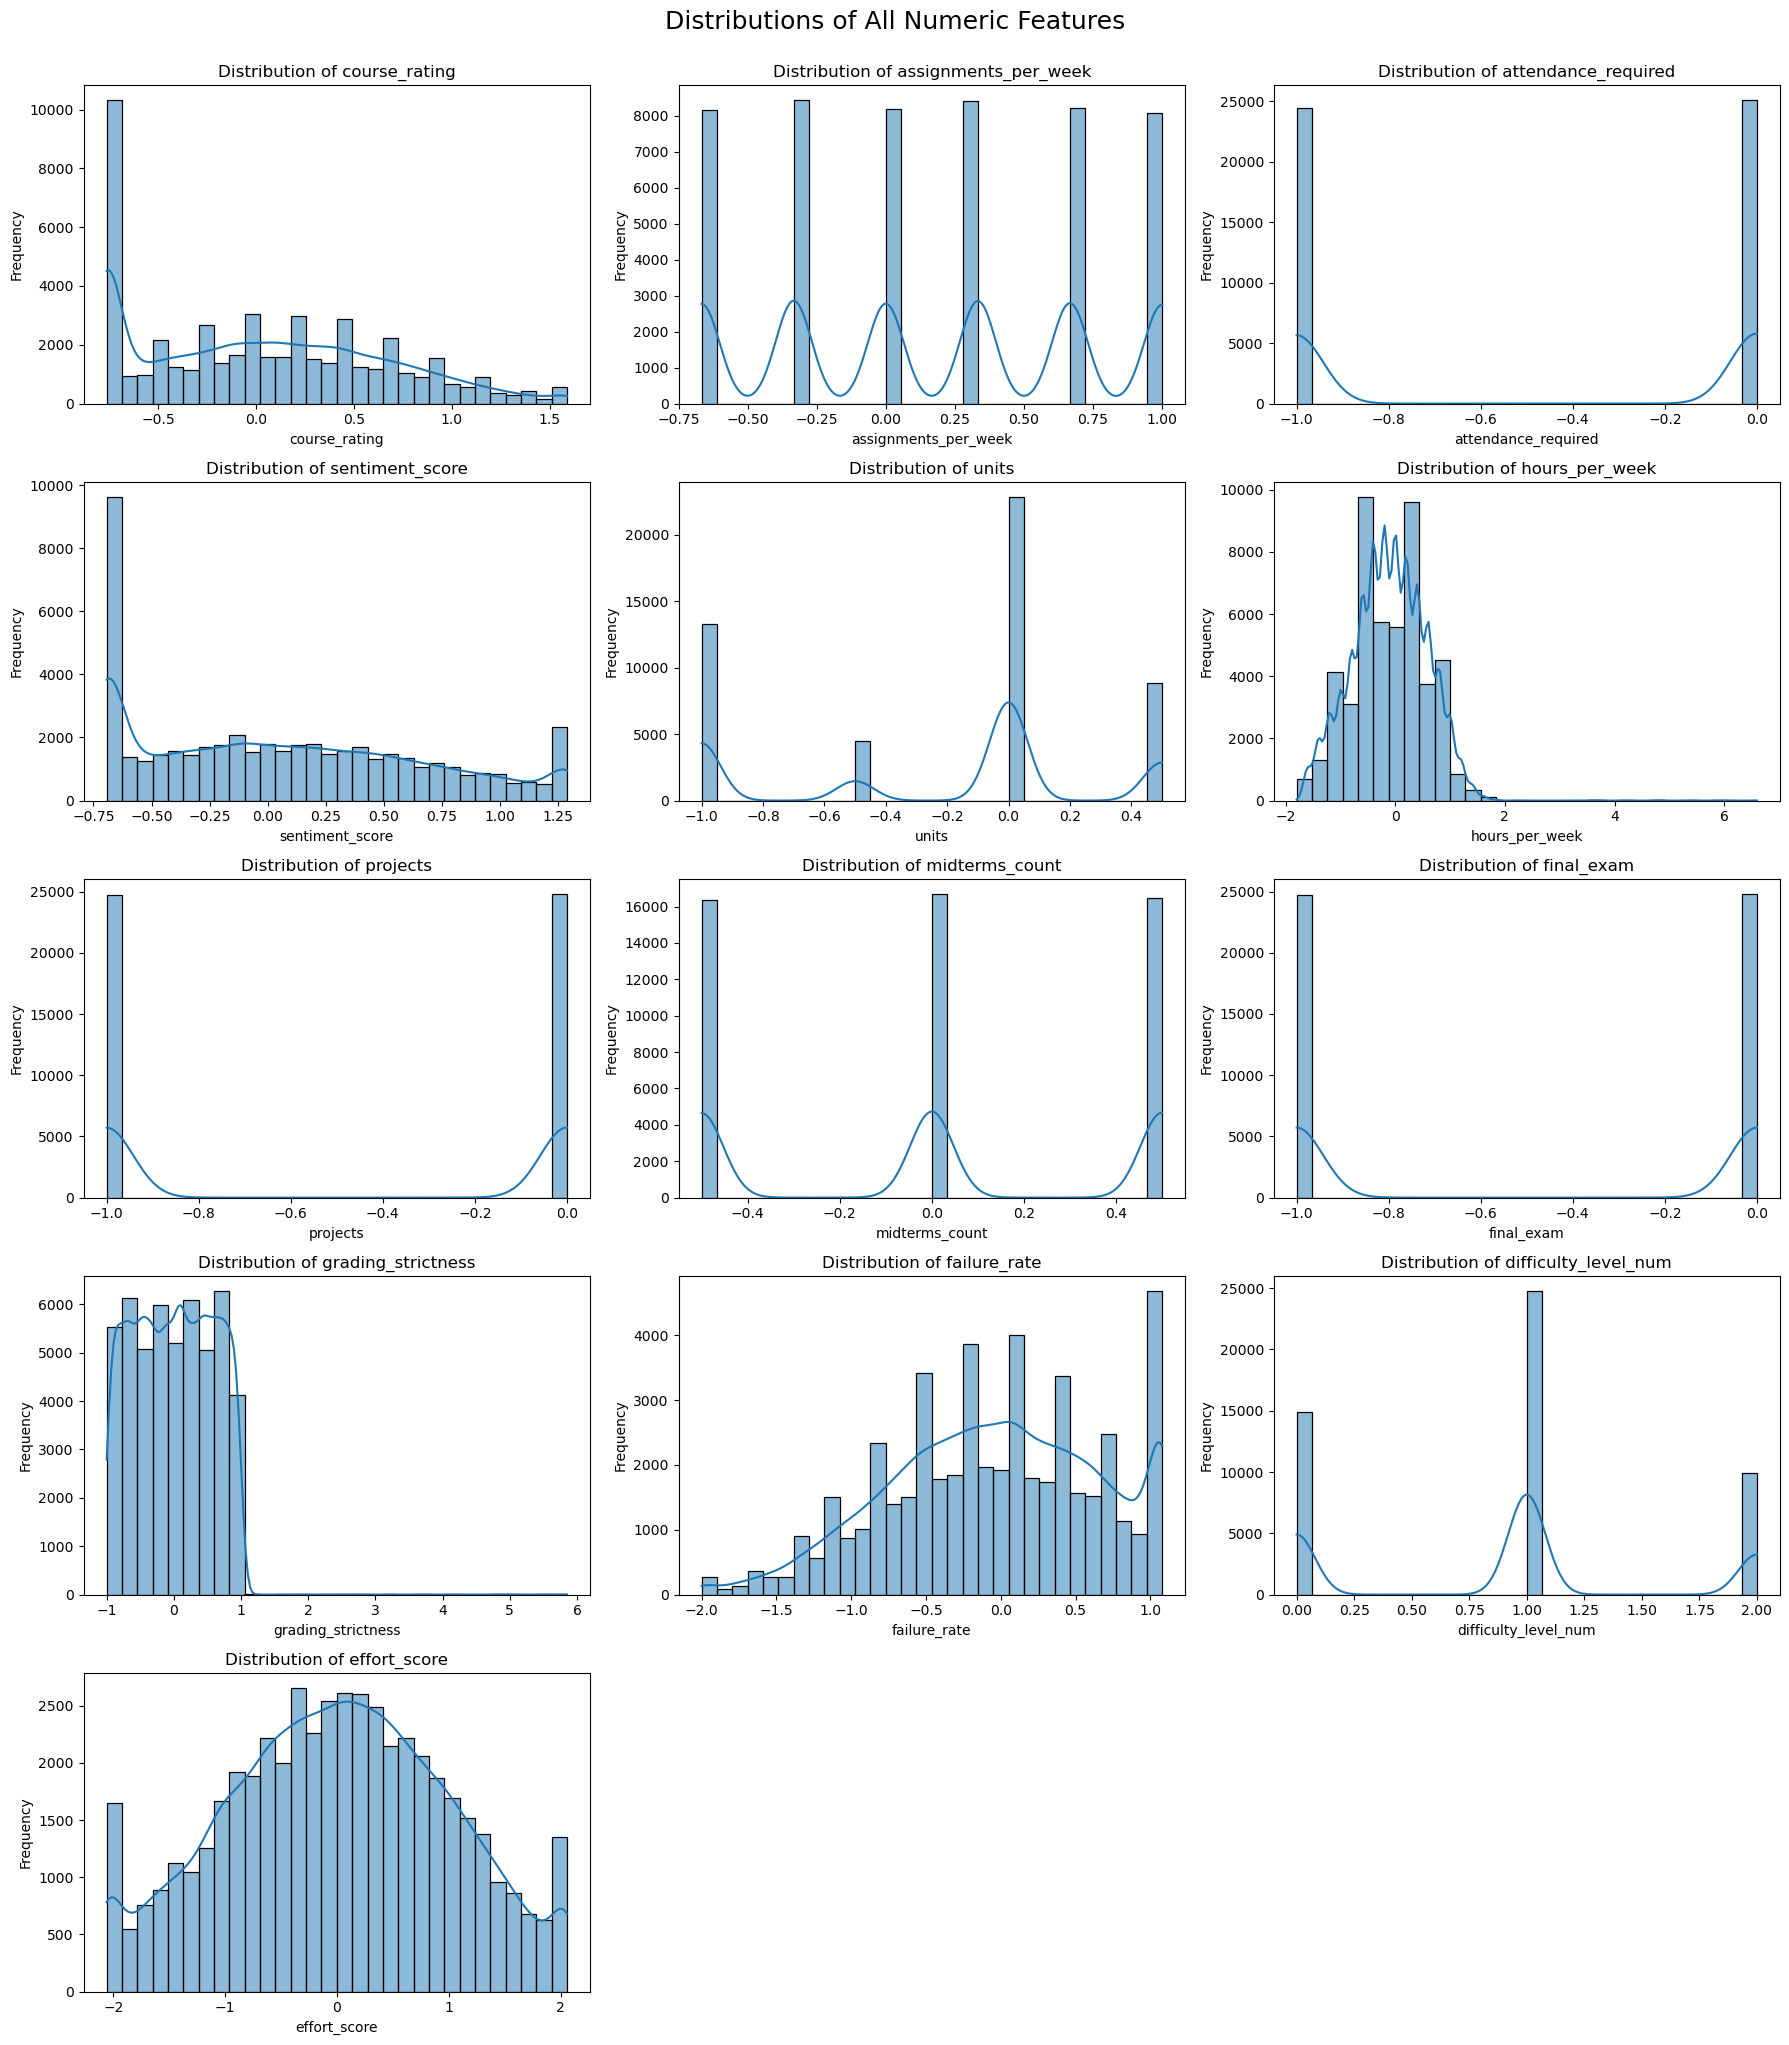

In [ ]:
plot_histogram_grid(
    df=df_fe,
    features=df_fe.select_dtypes(include='number').columns.tolist(),
    title="Distributions of All Numeric Features",
    bins=30
)



#### Final Numeric Feature Distributions (Trends)

- **course_rating**: Skewed left : most ratings are low.  
- **assignments_per_week**: Shows fixed values : like 0, 1, 2…  
- **attendance_required**: Binary : mostly 0 or 1.  
- **sentiment_score**: Left-skewed : students are often negative.  
- **units**: Few common values : likely 3 or 4 units per course.  
- **hours_per_week**: Looks normal : most courses have moderate workload.  
- **projects**, **midterms_count**, **final_exam**: Mostly binary : either present or not.  
- **grading_strictness**: Fairly spread out : varies across courses.  
- **failure_rate**: Right-skewed : some courses have high failure rates.  
- **drop_rate**: Symmetric : drops are common in all course types.  
- **difficulty_level_num**: Three clear levels : easy, medium, hard.  
- **effort_score**: Bell-shaped : most students report average effort.

------------

Save final cleaned and feature-engineered dataset

In [ ]:
df_fe.to_csv("cleaned_course_difficulty_dataset.csv", index=False)
print("Final dataset saved as 'cleaned_course_difficulty_dataset.csv'")


Final dataset saved as 'cleaned_course_difficulty_dataset.csv'


# Final Summary

This section of the project focused on generating and preparing a synthetic dataset to explore course difficulty. We simulated realistic university course data by designing features with logical dependencies (for example hours vs units or grading vs failure rates), and injected noise, missing values, and outliers to reflect real-world data imperfections.

Throughout the process, we conducted data analysis at each stage - including correlation checks, distribution plots, and class balance reviews - to ensure that our transformations preserved meaningful patterns and introduced variability responsibly.

Key steps included:
- Injecting logical and extreme anomalies into selected features
- Cleaning missing and inconsistent values
- Detecting and removing outliers using Z-score and IQR methods
- Engineering new features like `effort_score`
- Dropping features with high correlation (>|0.8|) to reduce redundancy
- Scaling numerical columns for modeling readiness

The resulting dataset is now structured, interpretable, and ready for training.
